In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm

In [109]:
import warnings
warnings.filterwarnings("ignore")

In [110]:
df = pd.read_csv('sales_data.csv')

## Data Cleaning

### Feature Reduction

In [112]:
# remove id columns 
df = df.drop(columns=['Order ID', 'Product_ean', 'catégorie', 'Purchase Address'])

### Check for Missing Values 

In [114]:
#check for missing values in the entire dataframe
df.isnull().sum()

Order Date          0
Product             0
Quantity Ordered    0
Price Each          0
Cost price          0
turnover            0
margin              0
dtype: int64

### Reformat Data types

In [116]:
# Covert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

## Exploratory Analysis

In [118]:
# Compare the number of items sold by product
items_sold = df['Product'].groupby(df['Product']).count().sort_values()

Text(0.5, 1.0, 'Number of items sold')

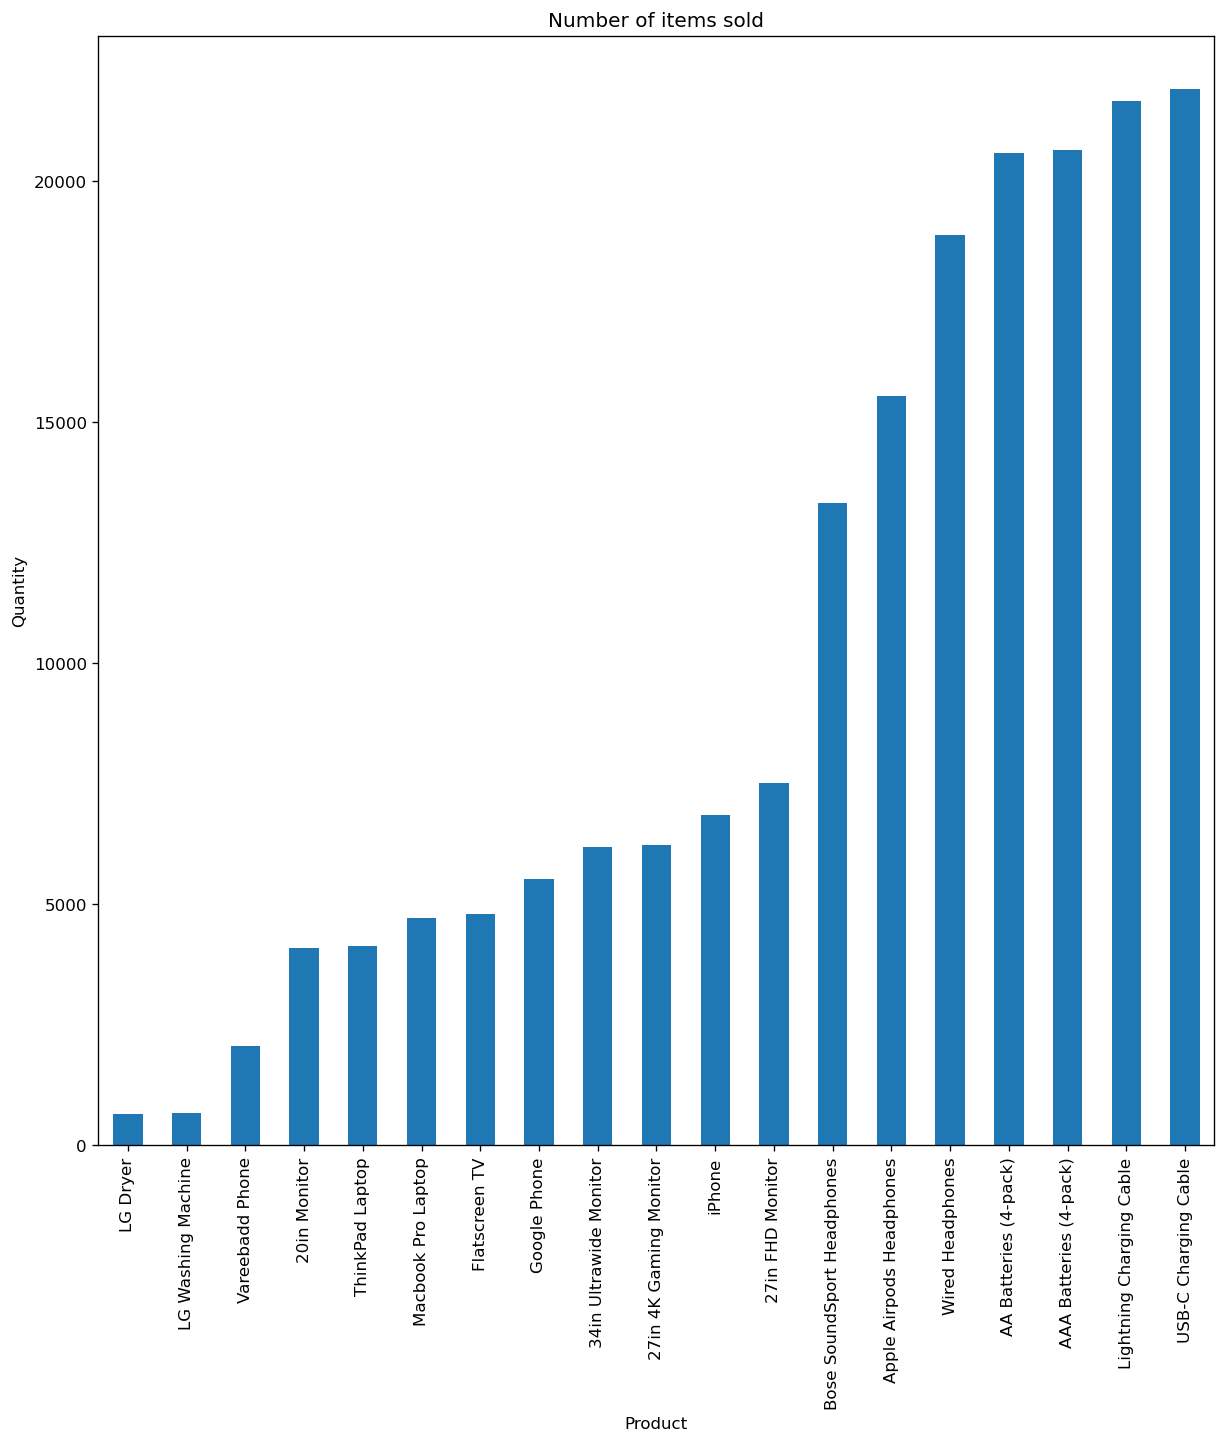

In [120]:
items_sold.plot(kind='bar')
plt.figure(figsize=(8,5))
plt.ylabel('Quantity')
plt.title('Number of items sold')

In [121]:
# Compare the revenue generated by product
sum_sold = df['margin'].groupby(df['Product']).sum().sort_values()

Text(0.5, 1.0, 'Revenue by Product Sold')

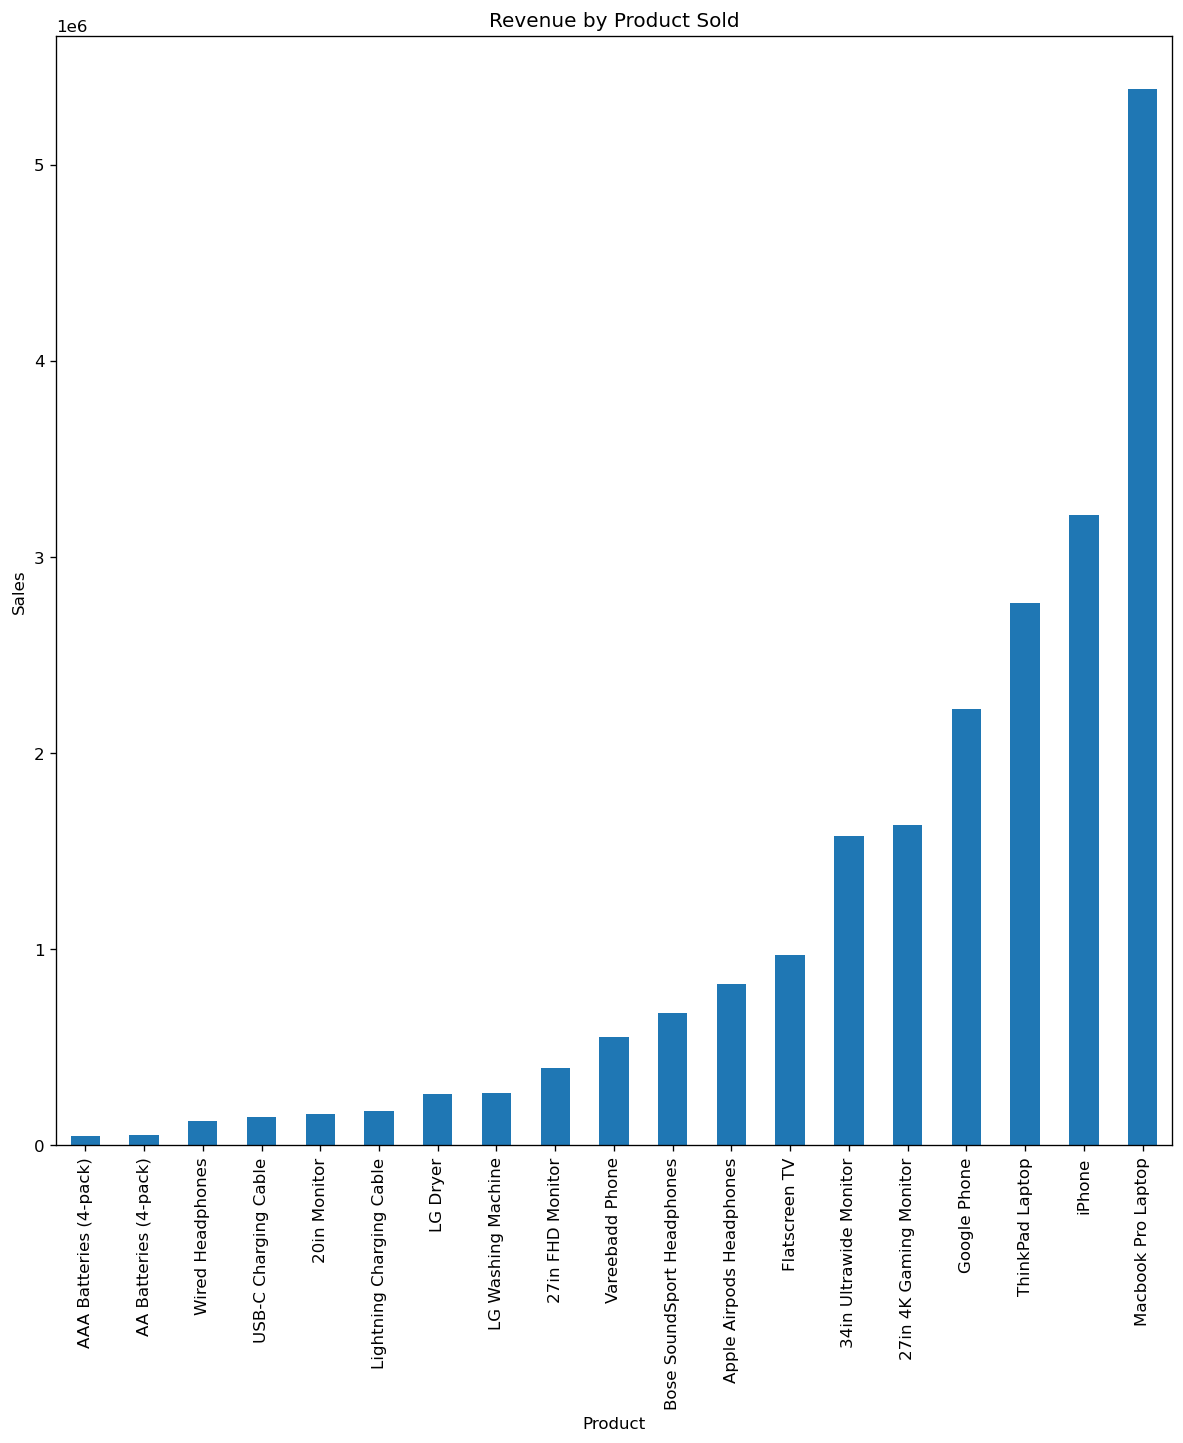

In [123]:
sum_sold.plot(kind='bar')
plt.ylabel('Sales')
plt.title('Revenue by Product Sold')

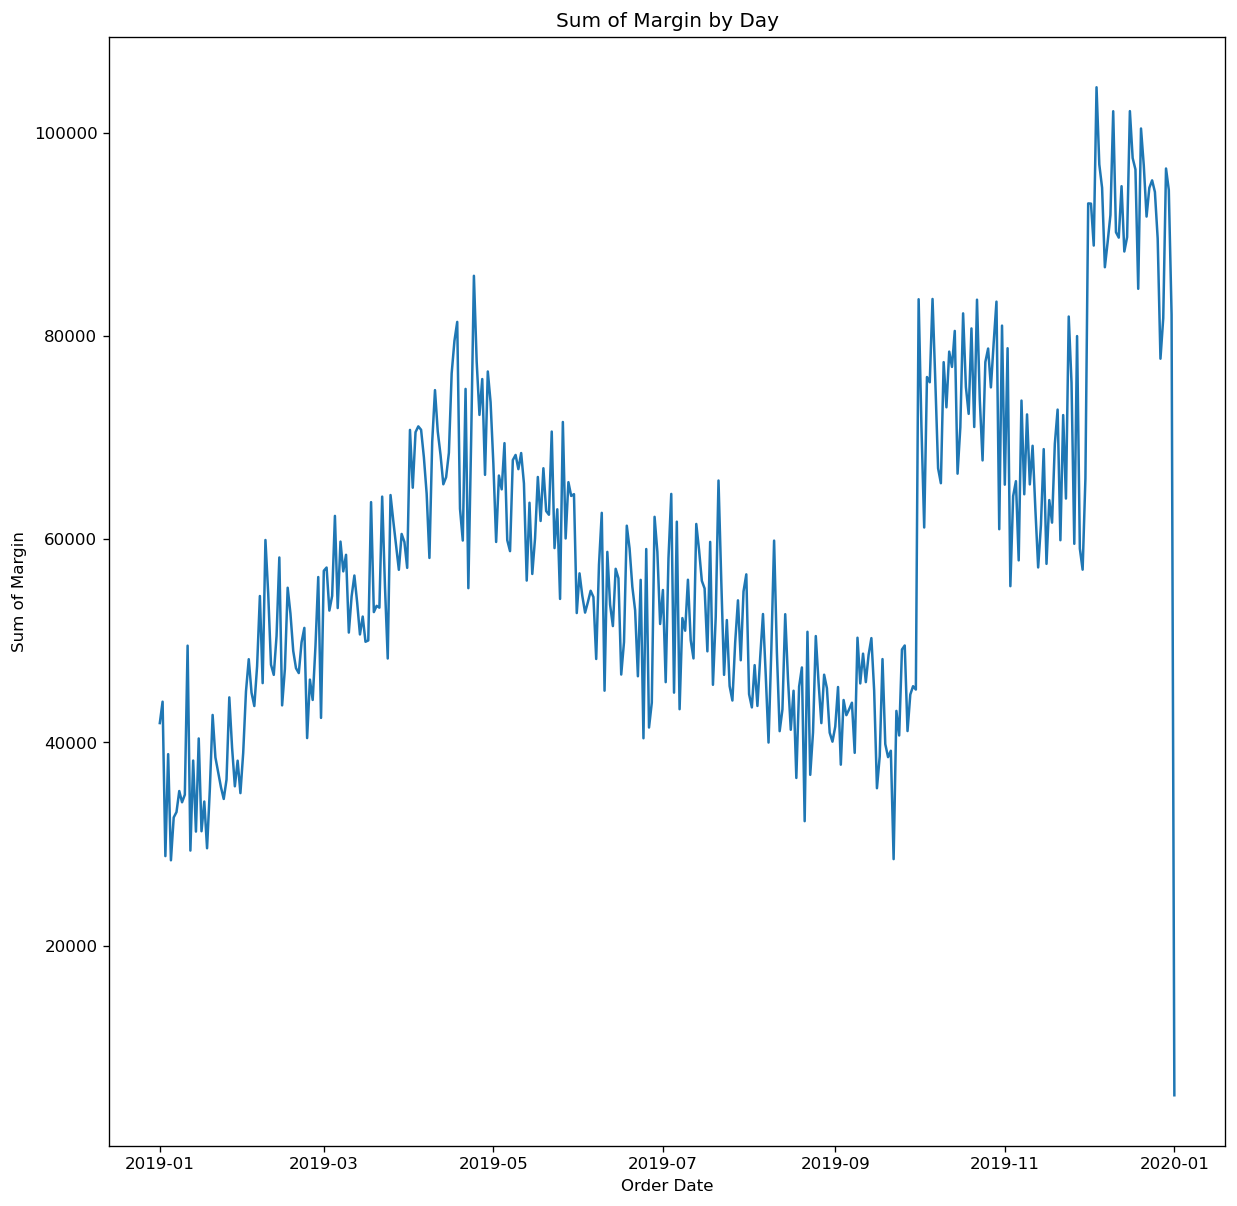

In [124]:
# calcuate the profit margins generate by date
daily_margin = df.groupby(df['Order Date'].dt.date)['margin'].sum().reset_index()

plt.plot(daily_margin['Order Date'], daily_margin['margin'])

# Adding labels and title to the graph
plt.xlabel('Order Date')
plt.ylabel('Sum of Margin')
plt.title('Sum of Margin by Day')

# Displaying the graph
plt.show()

In [ ]:
# Assuming the dataset is stored in a pandas DataFrame called 'df'
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Grouping the data by product and day, and calculating the sum of the 'margin' column
product_margin = df.groupby(['Product', df['Order Date'].dt.date])['margin'].sum().reset_index()

# Creating a graph for each product
for product in df['Product'].unique():
    product_data = product_margin[product_margin['Product'] == product]
    plt.plot(product_data['Order Date'], product_data['margin'])
    plt.xlabel('Order Date')
    plt.ylabel('Sum of Margin')
    plt.title(f'Sum of Margin for {product}')
    plt.show()

## Explore the Target Feature, Profit Margin

In [126]:
df['margin'].describe()

count    185950.000000
mean        115.289422
std         225.227190
min           1.495000
25%           5.975000
50%           7.475000
75%          52.500000
max        2278.000000
Name: margin, dtype: float64

### Check the Distribution of the Target Feature

Text(0, 0.5, 'Count')

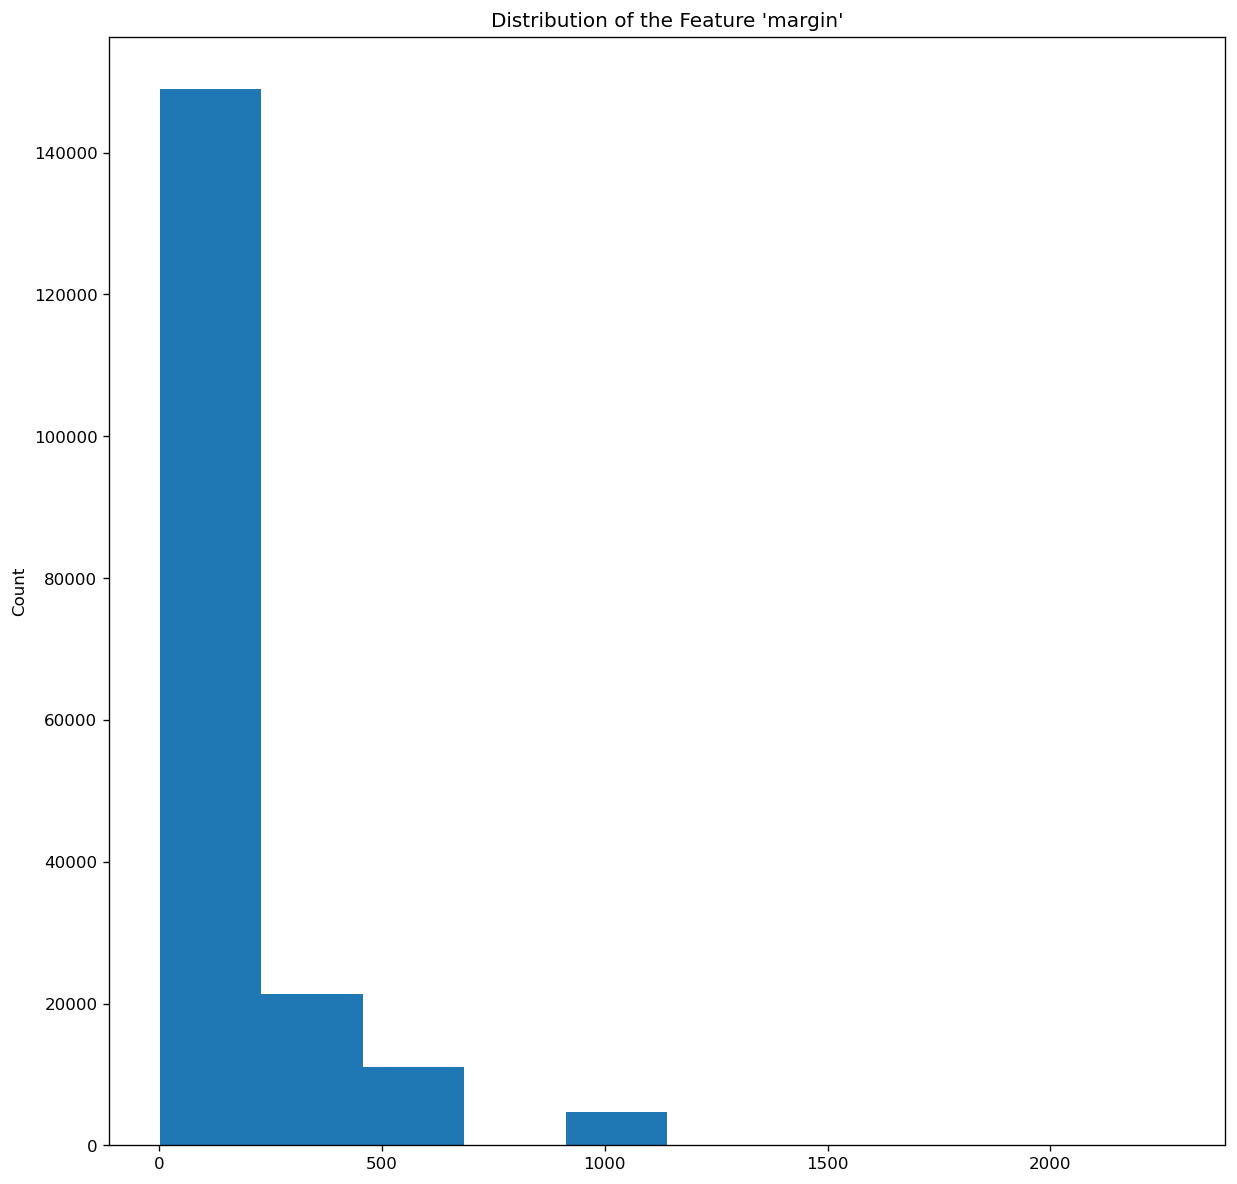

In [127]:
#plot the distribution of the target variable 
plt.hist(df['margin'])
plt.title("Distribution of the Feature 'margin'")
plt.ylabel("Count")

The histogram of profit margin shows a strong positive skew.

Text(0, 0.5, 'Count')

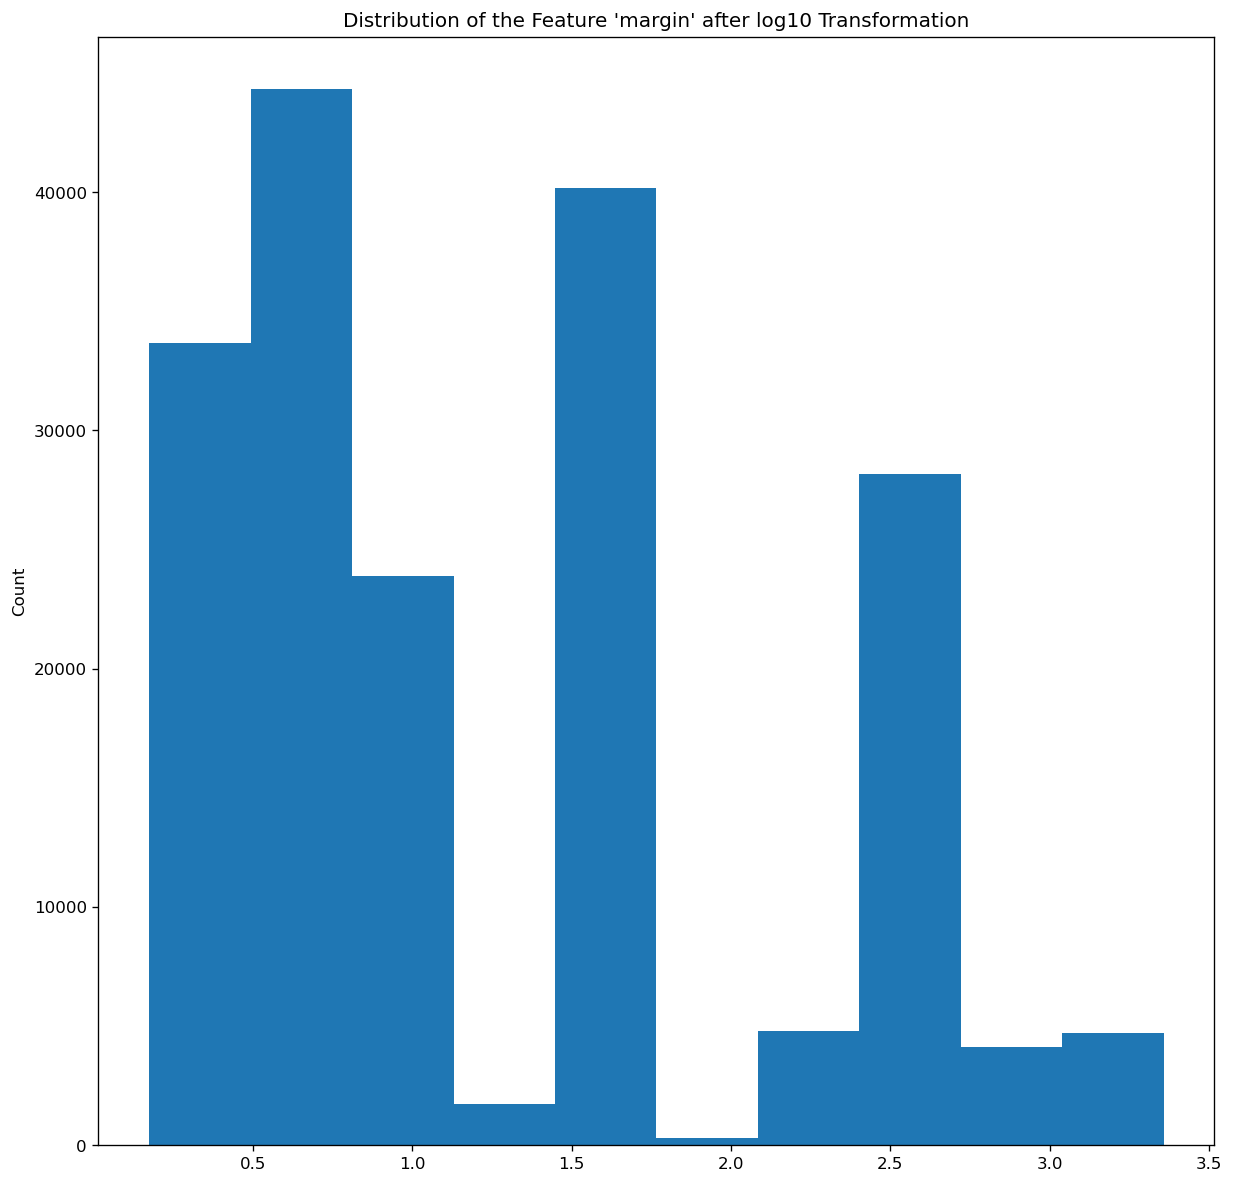

In [128]:
#use a log 10 transformation to correct the positive skew in the feature 'margin'
log_margin = np.log10(df['margin'])

plt.hist(log_margin)
plt.title("Distribution of the Feature 'margin' after log10 Transformation")
plt.ylabel("Count")

When a log 10 transformation is applied to the target variable, a multimodal distribition emerges. It should be evaluated if other transformations can generate a more normal distribution.

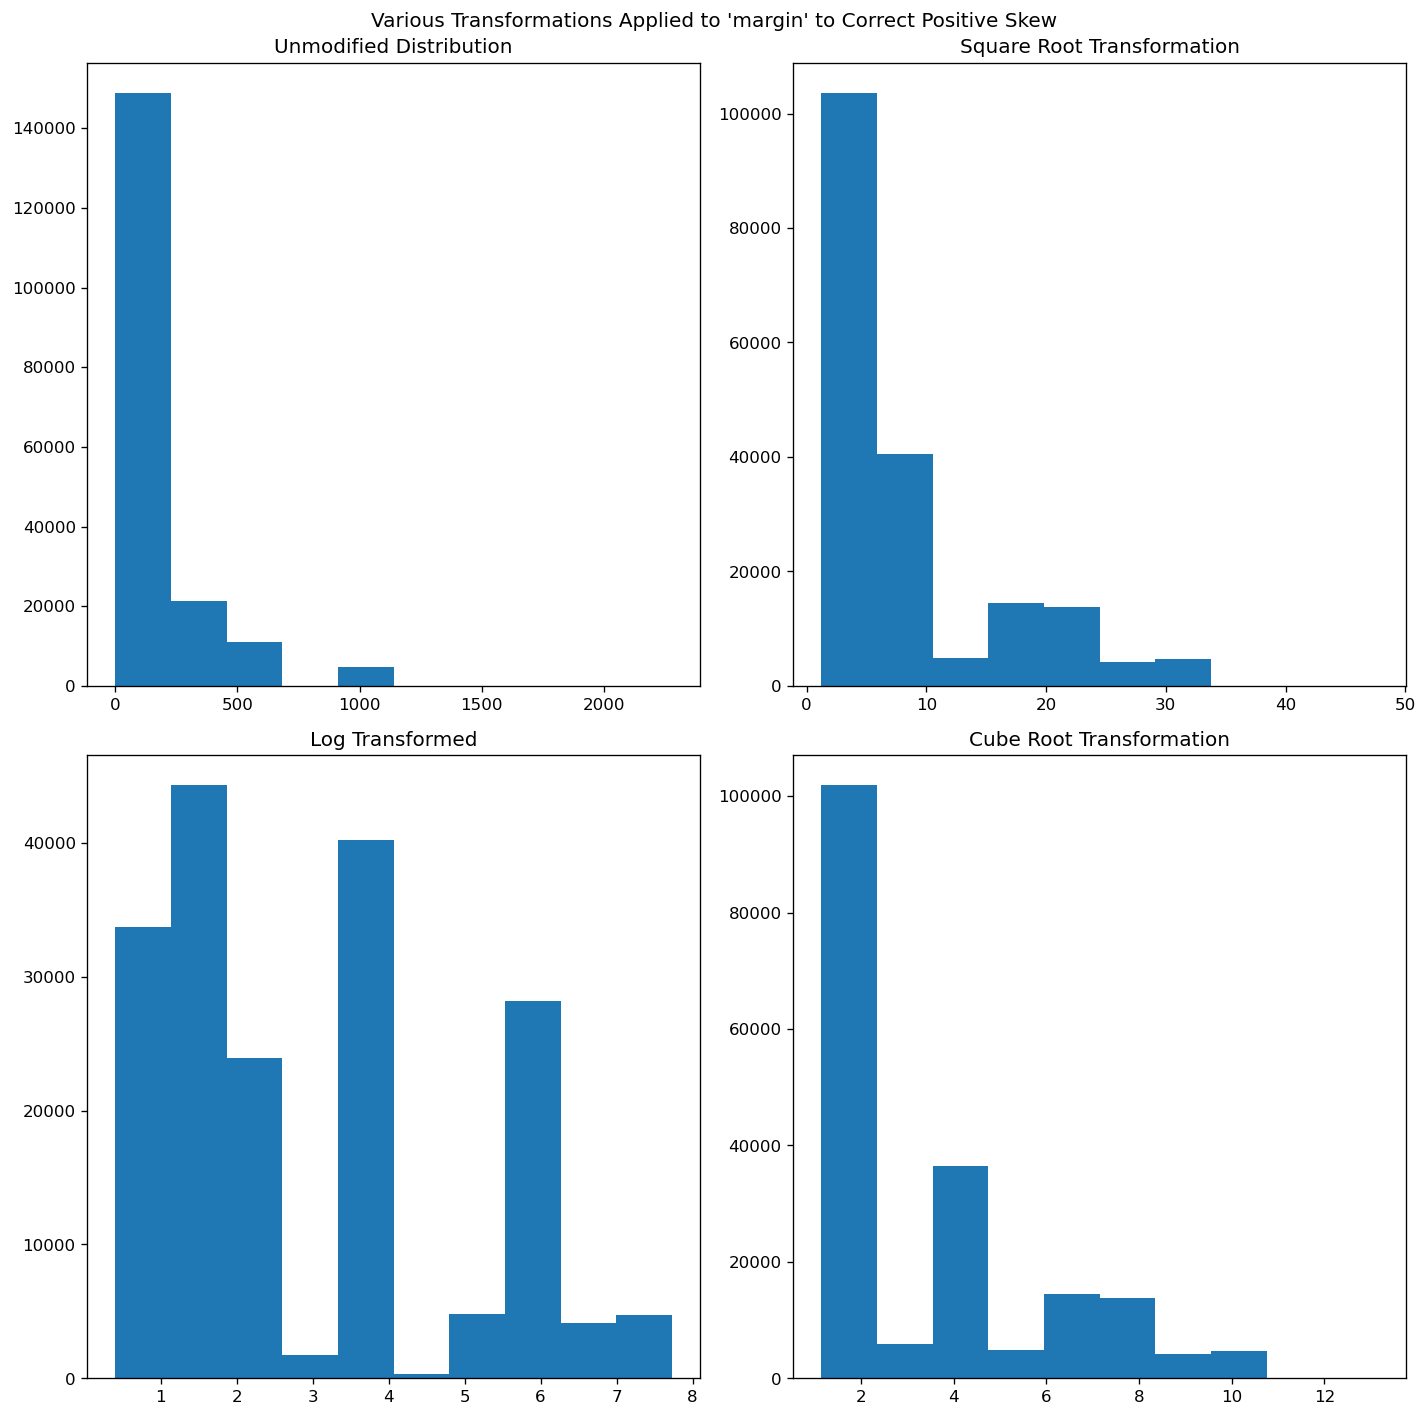

In [129]:
# Compare the effectiveness of various transformations for correcting the positive skew 

fig, axs = plt.subplots(2, 2)
fig.suptitle("Various Transformations Applied to 'margin' to Correct Positive Skew")
axs[0, 0].hist(df['margin'])
axs[0, 0].set_title("Unmodified Distribution")
axs[1, 0].hist(np.log(df['margin']))
axs[1, 0].set_title("Log Transformed")
axs[0, 1].hist(np.sqrt(df['margin']))
axs[0, 1].set_title("Square Root Transformation")
axs[1, 1].hist(np.cbrt(df['margin']))
axs[1, 1].set_title("Cube Root Transformation")
fig.tight_layout()

A log10 transformation is the most effective at correcting the postive skew.

Text(0.5, 1.0, "Distribution of log10 transformed 'Margins' with 6 bins")

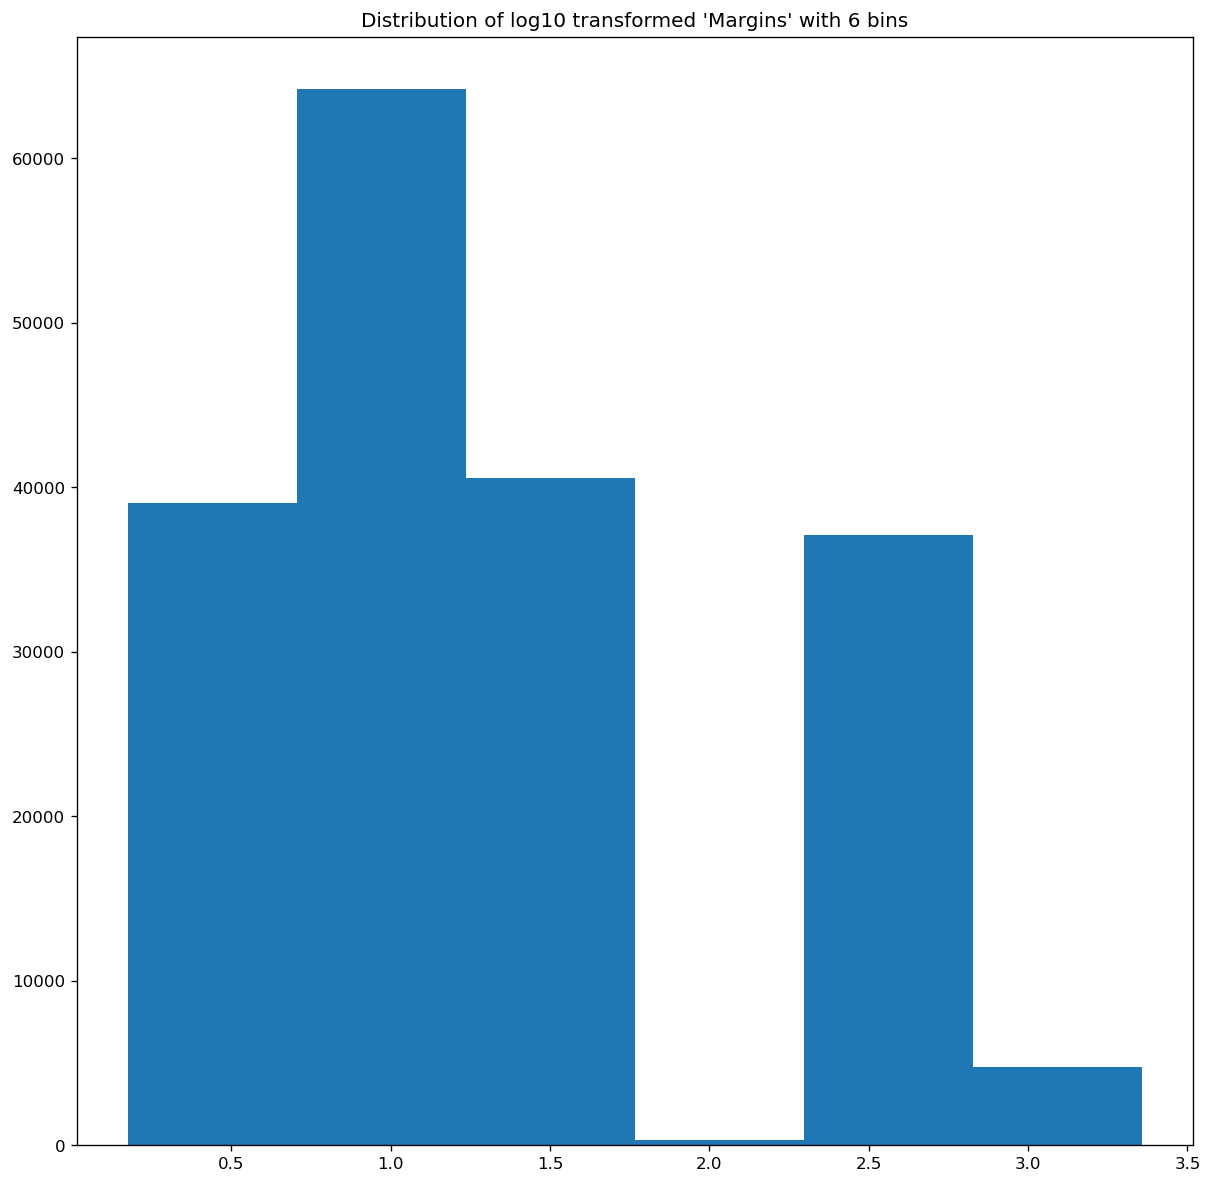

In [130]:
# Bin the data to correct the multimodal distribution 
plt.hist(np.log10(df['margin']), bins=6)
plt.title("Distribution of log10 transformed 'Margins' with 6 bins")

Binning the data into 6 bins reduces the effect of the multimodal distribution and the targer variable more closely approaches a normal distribution. 

### Check for Outliers in the Target Feature

Text(0.5, 1.0, 'Boxplot of Sale Margin')

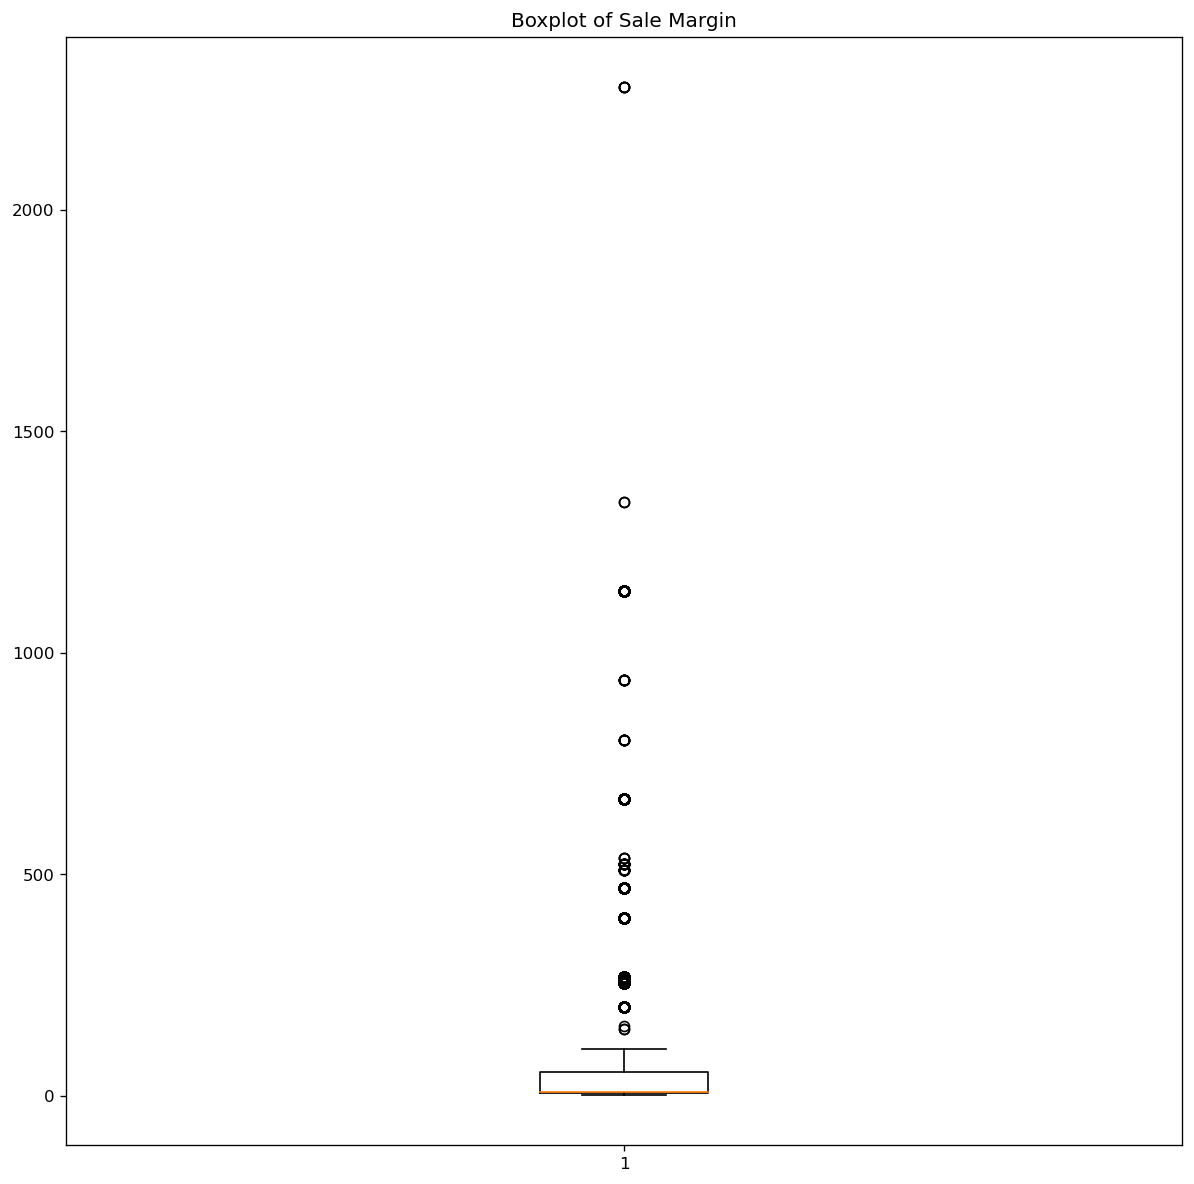

In [132]:
plt.boxplot(df['margin'])
plt.title("Boxplot of Sale Margin")

As expected in a feature with strong positive skew, the boxplot suggests a high number of outliers.

In [133]:
# calculate the upper and lower thresholds for outliers using IQR methodology
upper = np.percentile(df['margin'], 75) + 1.5*stats.iqr(df['margin'])
lower = np.percentile(df['margin'], 25) - 1.5*stats.iqr(df['margin'])

print(upper)
print(lower)

122.2875
-63.81249999999999


The upper threshold for identifying outliers is 122.2875, which is slightly above the mean. This is not surprising based on the strong skew shown in the histogram. The lower threshold is negative. This threshold will be ignored becuase there are no negative values of 'margin'. 

In [134]:
# create a dataframe of the outliers to investigate why there is such a large number of instance that are flagged as outliers 
outliers = df[df['margin']>upper]

outliers.head()

,Order Date,Product,Quantity Ordered,Price Each,Cost price,turnover,margin
0,2019-01-22 21:25:00,iPhone,1,700.00,231.0000,700.00,469.0000
6,2019-01-26 12:16:00,27in 4K Gaming Monitor,1,389.99,128.6967,389.99,261.2933
11,2019-01-31 10:12:00,Macbook Pro Laptop,1,1700.00,561.0000,1700.00,1139.0000
14,2019-01-03 21:54:00,Flatscreen TV,1,300.00,99.0000,300.00,201.0000
16,2019-01-10 11:20:00,Vareebadd Phone,1,400.00,132.0000,400.00,268.0000


In [136]:
# count the number of products sold in sales that were flagged as outliers 
outliers_sold = outliers['Product'].groupby(outliers['Product']).count().sort_values(ascending=True)
outliers_sold

Product
Apple Airpods Headphones         1
Bose SoundSport Headphones       2
LG Dryer                       646
LG Washing Machine             666
Vareebadd Phone               2065
ThinkPad Laptop               4128
Macbook Pro Laptop            4724
Flatscreen TV                 4800
Google Phone                  5525
34in Ultrawide Monitor        6181
27in 4K Gaming Monitor        6230
iPhone                        6842
Name: Product, dtype: int64

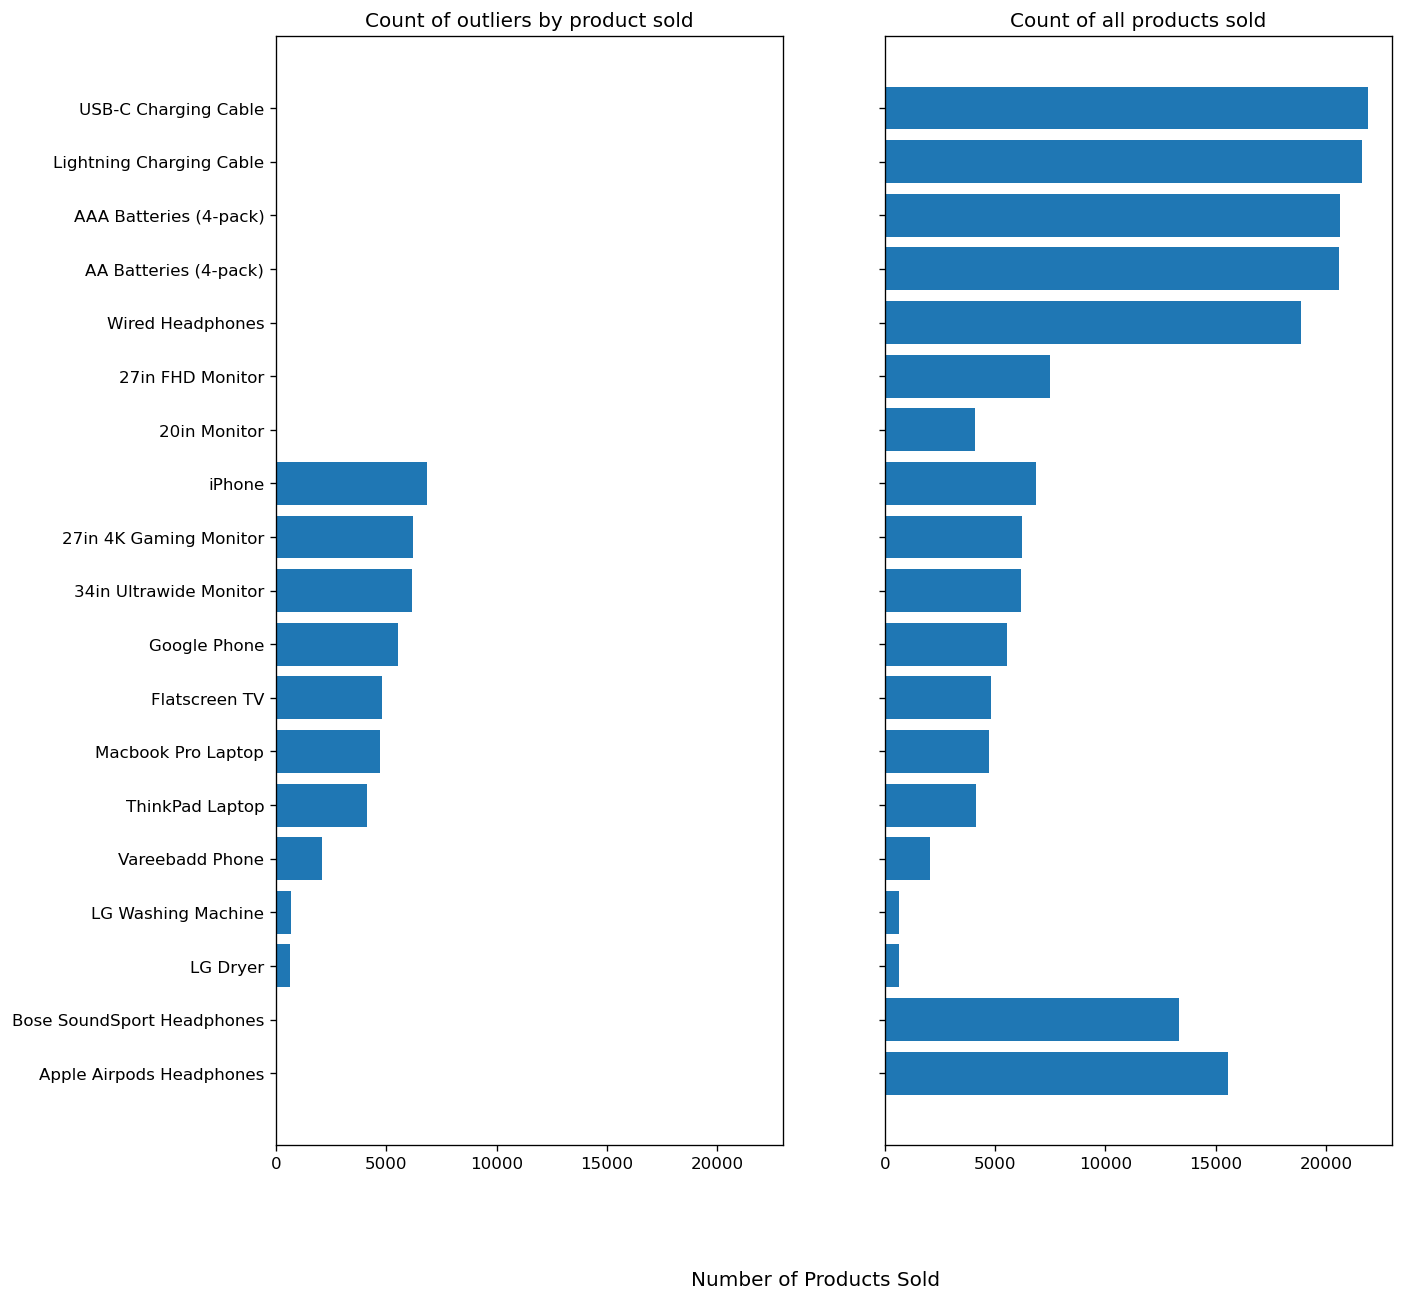

In [137]:
# plot the products that were identified as outliers next to all products sold 
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.supxlabel('Number of Products Sold')

ax1.barh(outliers_sold.index, outliers_sold)
ax1.set_title("Count of outliers by product sold")
ax2.barh(items_sold.index, items_sold)
ax2.set_title("Count of all products sold")

plt.show()

In the bar graph above, it appears that the presence of outliers in item profit margin is associated with the specific product being sold.

In [138]:
# determine if all sales for specific items are considered outliers 
for x in outliers_sold.index: 
    if outliers_sold[x] == items_sold[x]:
        print("True", x)
    else:
        print("False", x)

False Apple Airpods Headphones
False Bose SoundSport Headphones
True LG Dryer
True LG Washing Machine
True Vareebadd Phone
True ThinkPad Laptop
True Macbook Pro Laptop
True Flatscreen TV
True Google Phone
True 34in Ultrawide Monitor
True 27in 4K Gaming Monitor
True iPhone


All products in the outliers dataframe except two were exclusively outliers. The two exceptions (Apple Airpods and Bose SoundSport Headphones) are likely to contain authentic outliers. The other products were likely flagged as outliers because their profit margin is signifcantly higher than other products. It may be best to separate out these products and treat them as a separate dataset. 

In [139]:
#confirm the data accuaracy of the three inconsistent observations in the outlier dataframe 
outliers[(outliers['Product']== 'Apple Airpods Headphones') | (outliers['Product']=='Bose SoundSport Headphones')]

,Order Date,Product,Quantity Ordered,Price Each,Cost price,turnover,margin
74751,2019-06-03 20:37:00,Bose SoundSport Headphones,3,99.99,49.995,299.97,149.985
96771,2019-07-29 19:51:00,Bose SoundSport Headphones,3,99.99,49.995,299.97,149.985
175842,2019-12-31 21:37:00,Apple Airpods Headphones,3,150.00,97.500,450.00,157.500


In [140]:
# view these product details in the original dataframe 
df[(df['Product']== 'Apple Airpods Headphones') | (df['Product']=='Bose SoundSport Headphones')]

,Order Date,Product,Quantity Ordered,Price Each,Cost price,turnover,margin
8,2019-01-01 10:30:00,Bose SoundSport Headphones,1,99.99,49.995,99.99,49.995
9,2019-01-22 21:20:00,Apple Airpods Headphones,1,150.00,97.500,150.00,52.500
10,2019-01-07 11:29:00,Apple Airpods Headphones,1,150.00,97.500,150.00,52.500
17,2019-01-24 08:13:00,Apple Airpods Headphones,1,150.00,97.500,150.00,52.500
23,2019-01-12 18:51:00,Apple Airpods Headphones,1,150.00,97.500,150.00,52.500
...,...,...,...,...,...,...,...
185929,2019-12-18 08:29:00,Apple Airpods Headphones,1,150.00,97.500,150.00,52.500
185935,2019-12-26 23:17:00,Apple Airpods Headphones,1,150.00,97.500,150.00,52.500
185939,2019-12-16 17:41:00,Apple Airpods Headphones,1,150.00,97.500,150.00,52.500
185941,2019-12-31 19:07:00,Bose SoundSport Headphones,1,99.99,49.995,99.99,49.995


The cost of goods and the price sold is matches in both datasets. These instances were flagged as outliers because the number of items purchased pushed the margin of the sale above the upper outlier threshold. These values should not be removed. 

## Check the distribution of 'margin' in the separated datasets

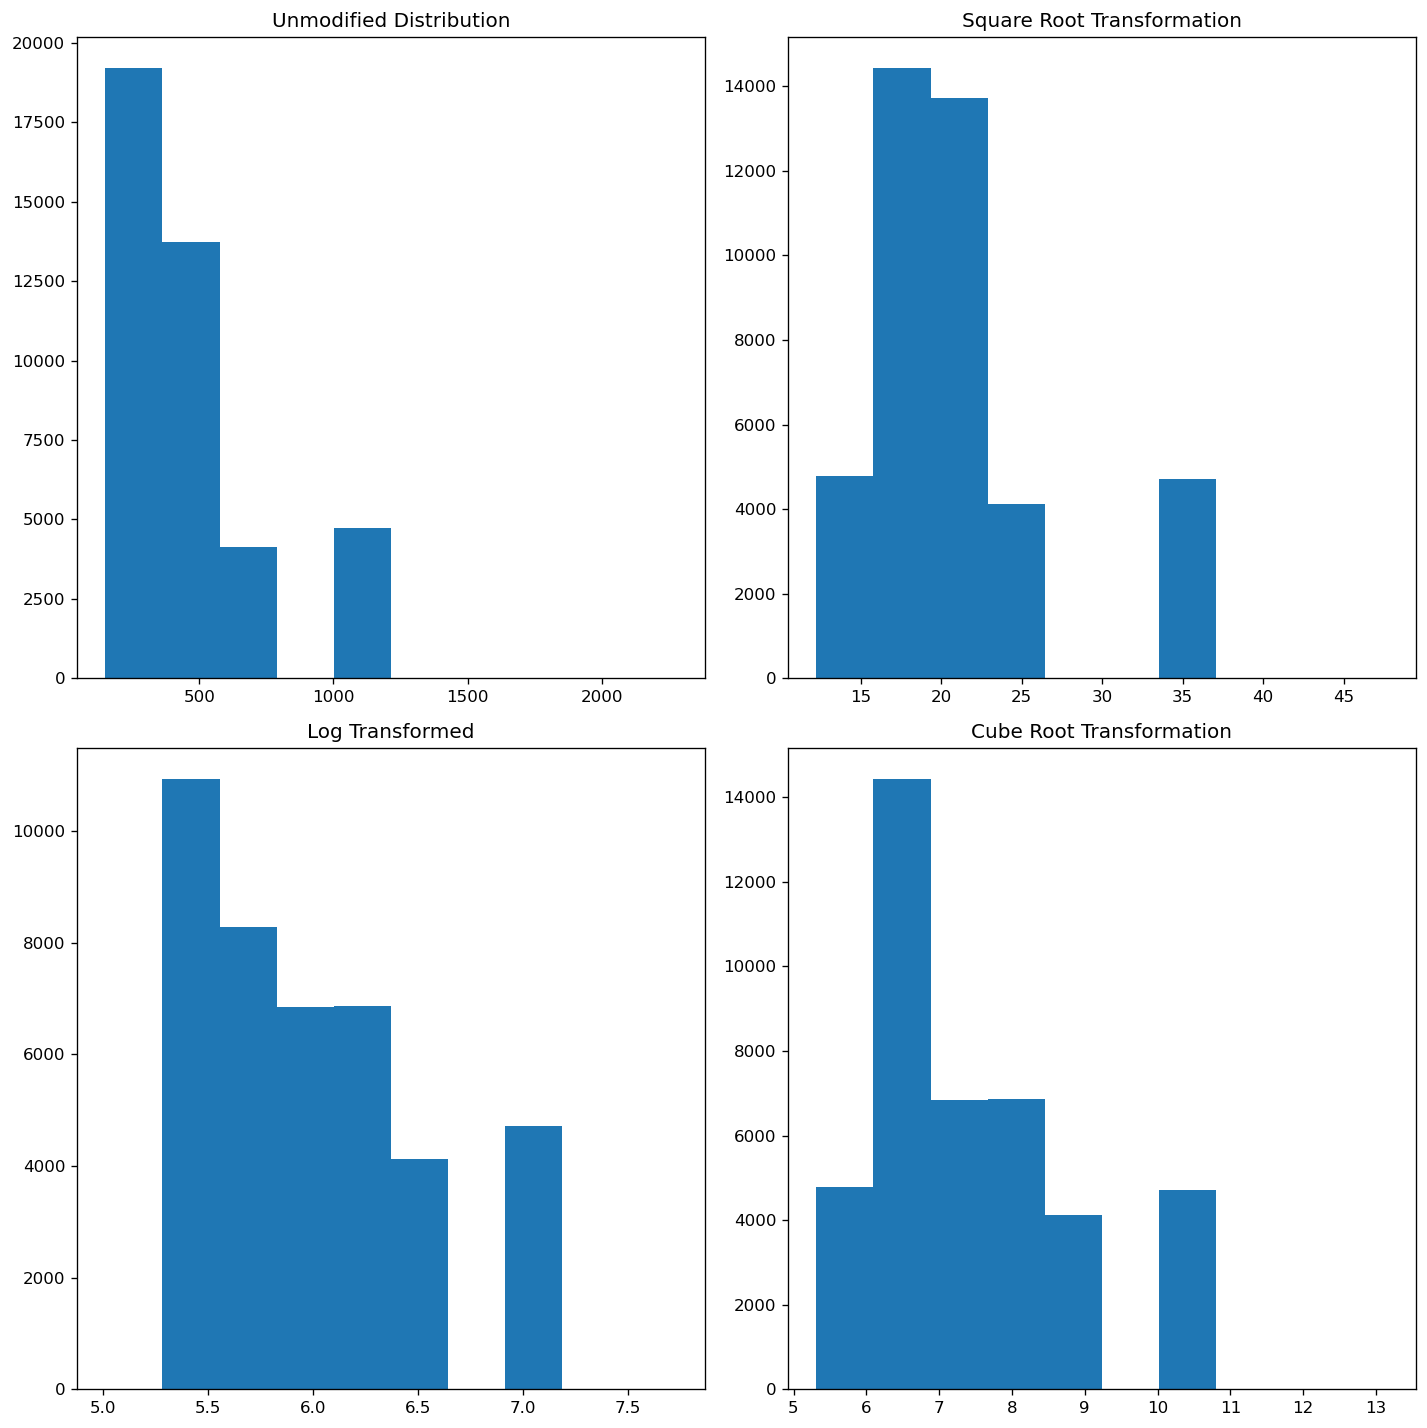

In [141]:
# View the distribution of margins in the outlier dataset 
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(outliers['margin'])
axs[0, 0].set_title("Unmodified Distribution")
axs[1, 0].hist(np.log(outliers['margin']))
axs[1, 0].set_title("Log Transformed")
axs[0, 1].hist(np.sqrt(outliers['margin']))
axs[0, 1].set_title("Square Root Transformation")
axs[1, 1].hist(np.cbrt(outliers['margin']))
axs[1, 1].set_title("Cube Root Transformation")
fig.tight_layout()

In [142]:
# create a dataframe of all observations not in the outliers data
df2 = df[~df.index.isin(outliers.index)]

df2.head()

,Order Date,Product,Quantity Ordered,Price Each,Cost price,turnover,margin
1,2019-01-28 14:15:00,Lightning Charging Cable,1,14.95,7.4750,14.95,7.4750
2,2019-01-17 13:33:00,Wired Headphones,2,11.99,5.9950,23.98,11.9900
3,2019-01-05 20:33:00,27in FHD Monitor,1,149.99,97.4935,149.99,52.4965
4,2019-01-25 11:59:00,Wired Headphones,1,11.99,5.9950,11.99,5.9950
5,2019-01-29 20:22:00,AAA Batteries (4-pack),1,2.99,1.4950,2.99,1.4950


(array([9.8798e+04, 4.7320e+03, 1.3000e+02, 4.0740e+03, 3.6097e+04,
        0.0000e+00, 0.0000e+00, 2.8000e+01, 0.0000e+00, 2.8100e+02]),
 array([  1.495 ,  11.8455,  22.196 ,  32.5465,  42.897 ,  53.2475,
         63.598 ,  73.9485,  84.299 ,  94.6495, 105.    ]),
 <BarContainer object of 10 artists>)

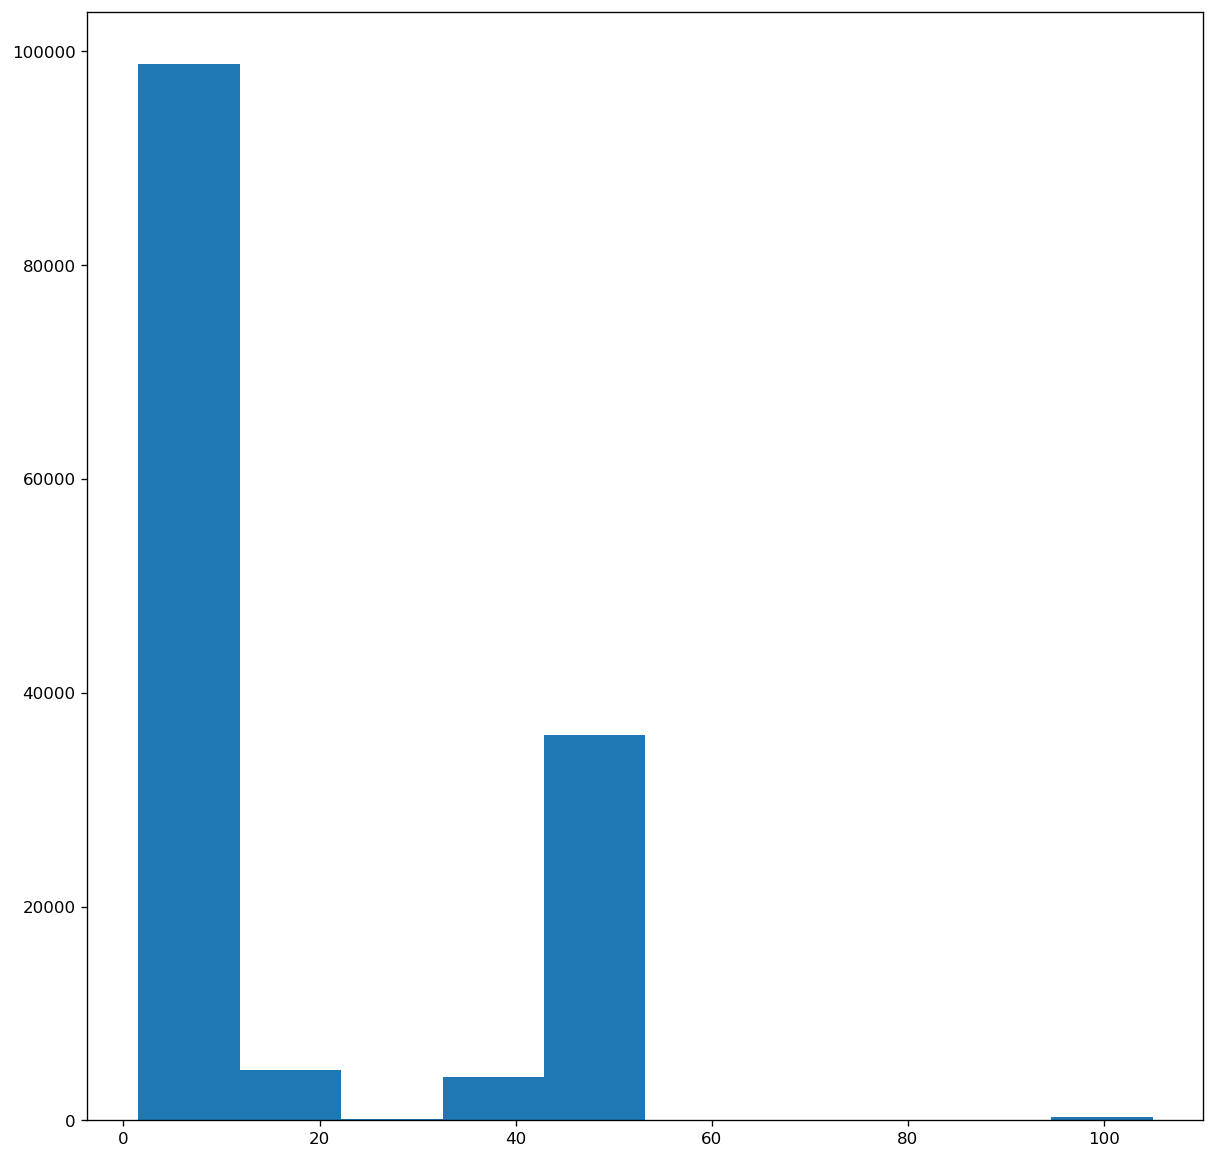

In [143]:
# plot the distribution of 'margin' of the original dataset with outliers removed
# low margin items 
plt.hist(df2['margin'])

Without the outliers included in the dataset, 'margins' has a bimodal distribution.

{'whiskers': [<matplotlib.lines.Line2D at 0x151cde6b0>,
 'caps': [<matplotlib.lines.Line2D at 0x151cdeda0>,
 'boxes': [<matplotlib.lines.Line2D at 0x151cde170>],
 'medians': [<matplotlib.lines.Line2D at 0x151cdda50>],
 'fliers': [<matplotlib.lines.Line2D at 0x151cdc310>],
 'means': []}

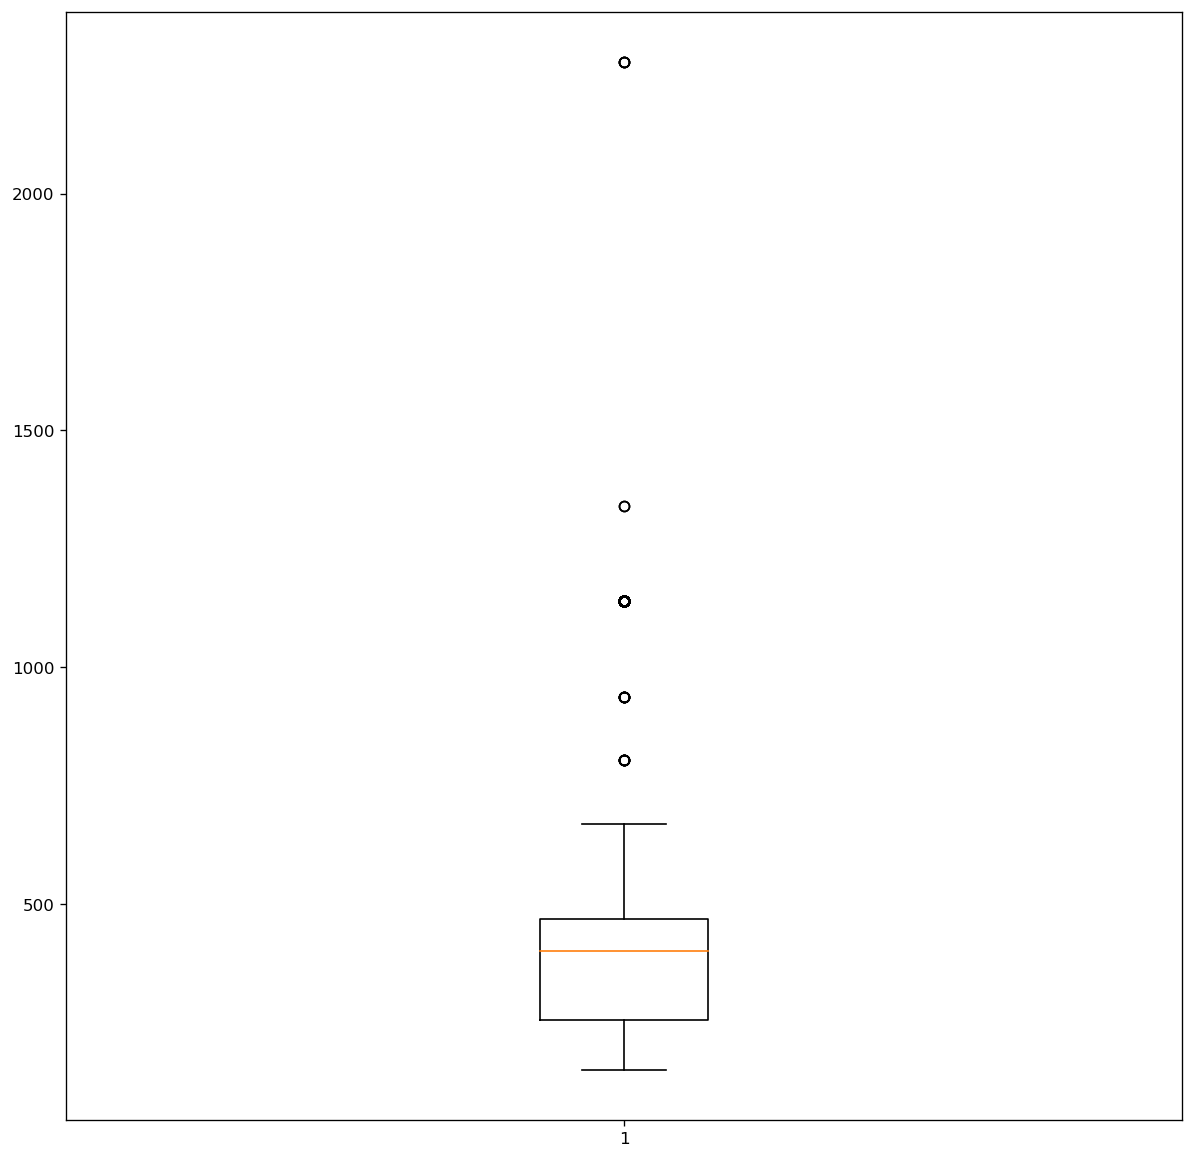

In [144]:
# check for outliers in outlier df
plt.boxplot(outliers['margin'])

In [145]:
# calculate outlier thresholds for the outlier df using IQR
upper2 = np.percentile(outliers['margin'], 75) + 1.5*stats.iqr(outliers['margin'])
lower2 = np.percentile(outliers['margin'], 25) - 1.5*stats.iqr(outliers['margin'])

print(upper2)
print(lower2)

790.61005
-67.01675


In [146]:
# create a new dataframe of outliers 
outliers2 = outliers[outliers['margin']>upper2]

outliers2.head()

,Order Date,Product,Quantity Ordered,Price Each,Cost price,turnover,margin
11,2019-01-31 10:12:00,Macbook Pro Laptop,1,1700.0,561.0,1700.0,1139.0
55,2019-01-19 08:17:00,Macbook Pro Laptop,1,1700.0,561.0,1700.0,1139.0
82,2019-01-13 23:51:00,Macbook Pro Laptop,1,1700.0,561.0,1700.0,1139.0
128,2019-01-17 21:00:00,Macbook Pro Laptop,1,1700.0,561.0,1700.0,1139.0
155,2019-01-10 12:59:00,Macbook Pro Laptop,1,1700.0,561.0,1700.0,1139.0


In [147]:
# count the number of products sold in sales that were flagged as outliers 
outliers2_sold = outliers2['Product'].groupby(outliers2['Product']).count().sort_values(ascending=True)
outliers2_sold

Product
ThinkPad Laptop          2
Google Phone             7
iPhone                   7
Macbook Pro Laptop    4724
Name: Product, dtype: int64

In [148]:
#eliminate MacBooks from the original outlier list
# high margin 
outliers3 = outliers[~outliers.index.isin(outliers2.index)]

(array([ 4784.,     0., 14441.,     0.,  6849.,     0.,  6853.,    17.,
            0.,  4126.]),
 array([149.985  , 201.98583, 253.98666, 305.98749, 357.98832, 409.98915,
        461.98998, 513.99081, 565.99164, 617.99247, 669.9933 ]),
 <BarContainer object of 10 artists>)

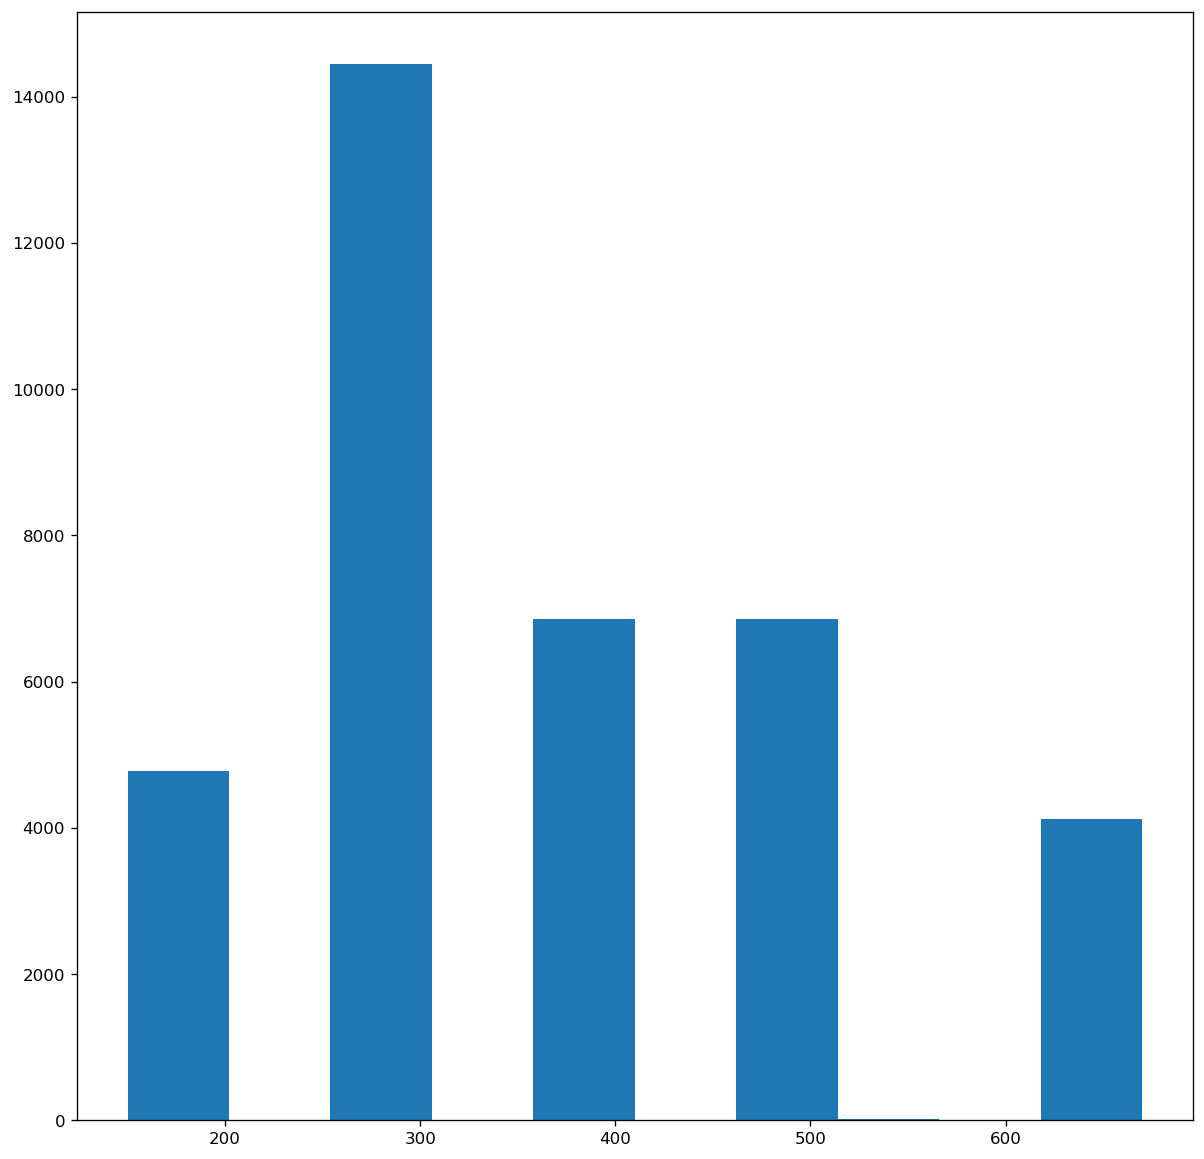

In [149]:
#high margin items except macbooks 
plt.hist((outliers3['margin']))

The distribution of 'margin' for the outlier df is almost normal after removing macbooks. This suggest that the original dataset should be divided into three datasets. 

(array([3.0000e+00, 4.7810e+03, 0.0000e+00, 1.4441e+04, 0.0000e+00,
        0.0000e+00, 6.8490e+03, 6.8350e+03, 3.5000e+01, 4.1260e+03]),
 array([5.01053529, 5.16020853, 5.30988177, 5.45955502, 5.60922826,
        5.7589015 , 5.90857474, 6.05824799, 6.20792123, 6.35759447,
        6.50726771]),
 <BarContainer object of 10 artists>)

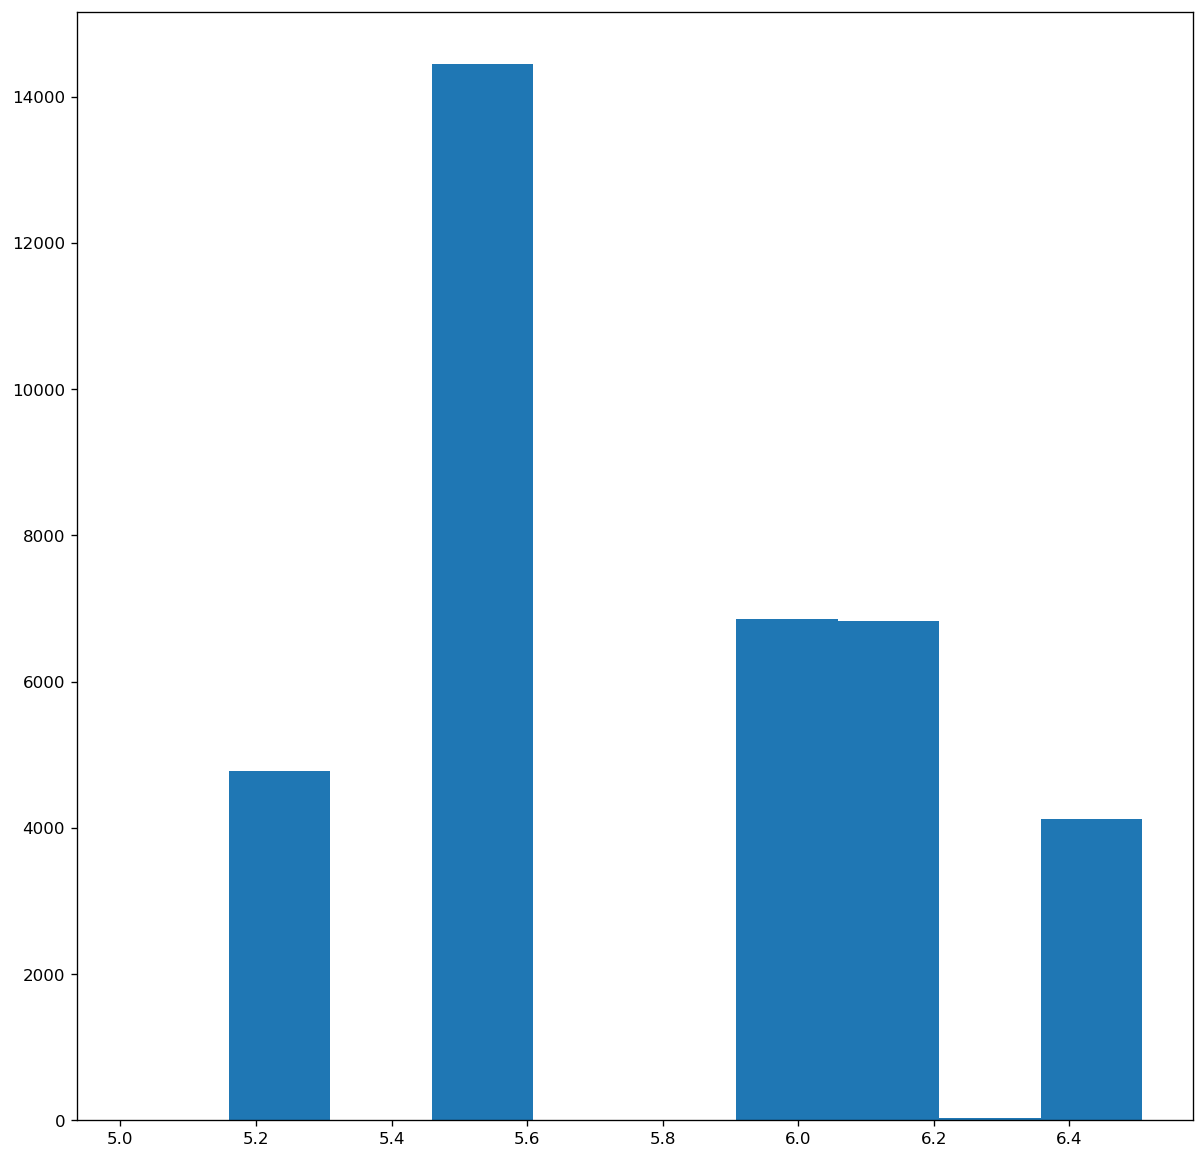

In [150]:
# apply log transformation to target feature 
plt.hist(np.log(outliers3['margin']))

## Build a model for the Very High Margin data subset 

### Prep the series

In [159]:
# group the sales into daily sum 
mcb = outliers2.groupby(df['Order Date'].dt.date)['margin'].sum()

Order Date
2019-01-01    10251.0
2019-01-02    10251.0
2019-01-03     4556.0
2019-01-04    11390.0
2019-01-05     4556.0
               ...   
2019-12-28    18224.0
2019-12-29    25862.0
2019-12-30    22780.0
2019-12-31    17085.0
2020-01-01     1139.0
Name: margin, Length: 366, dtype: float64

In [160]:
# drop the last row becuase it appears to be only half a day of data 
mcb = mcb.drop(mcb.index[365])

In [161]:
# take the log of the data to remove the positive skew 
mcb = np.log(mcb)

## Check the stationarity

In [162]:
# Utilize adf to test for stationarity 
result = adfuller(mcb.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.698054
p-value: 0.074376


The p-value is > .05, so the data is not stationary. It will need to be differenced

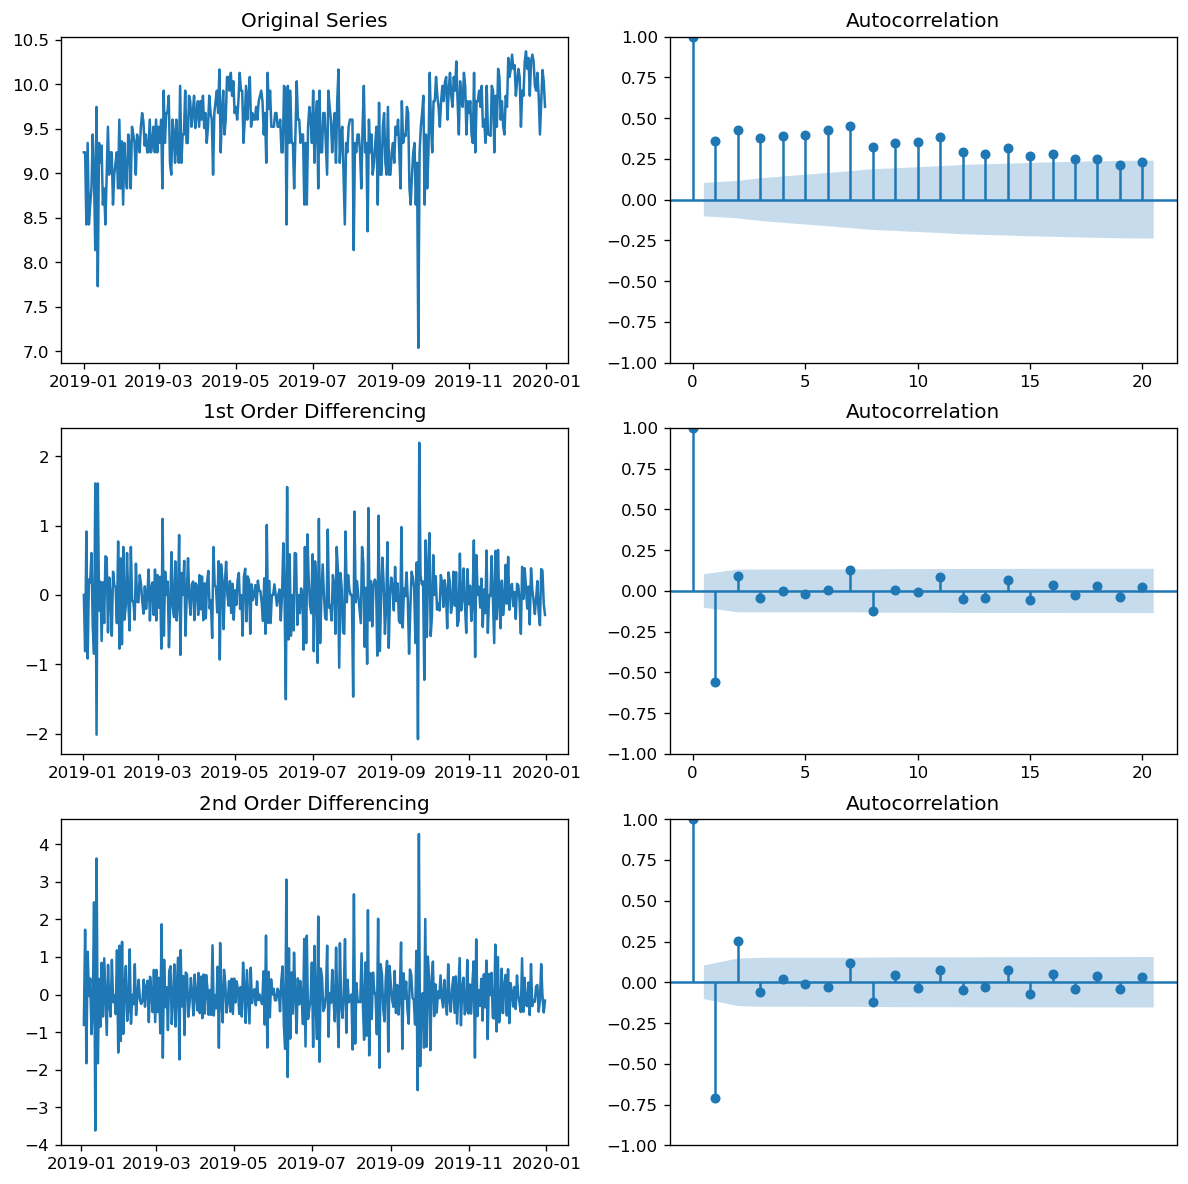

In [163]:
# Create a chart to check for stationality and view ACF  

plt.rcParams.update({'figure.figsize':(12,12), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(mcb); axes[0, 0].set_title('Original Series')
plot_acf(mcb, ax=axes[0, 1], lags=20)

# 1st Differencing
axes[1, 0].plot(mcb.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(mcb.diff().dropna(), ax=axes[1, 1], lags=20)

# 2nd Differencing
axes[2, 0].plot(mcb.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(mcb.diff().diff().dropna(), ax=axes[2, 1], lags=20)

plt.xticks([])
plt.show()

## Determine optimal p, d, q orders 

In [164]:
# use autoarima to determine the optimal orders 
aamodel = pm.auto_arima(mcb, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=300.146, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=543.169, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=410.171, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=302.760, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=541.171, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=302.137, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=300.606, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=300.065, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=302.003, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=304.059, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=299.307, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=302.302, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=299.380, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=301.193, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=299.4

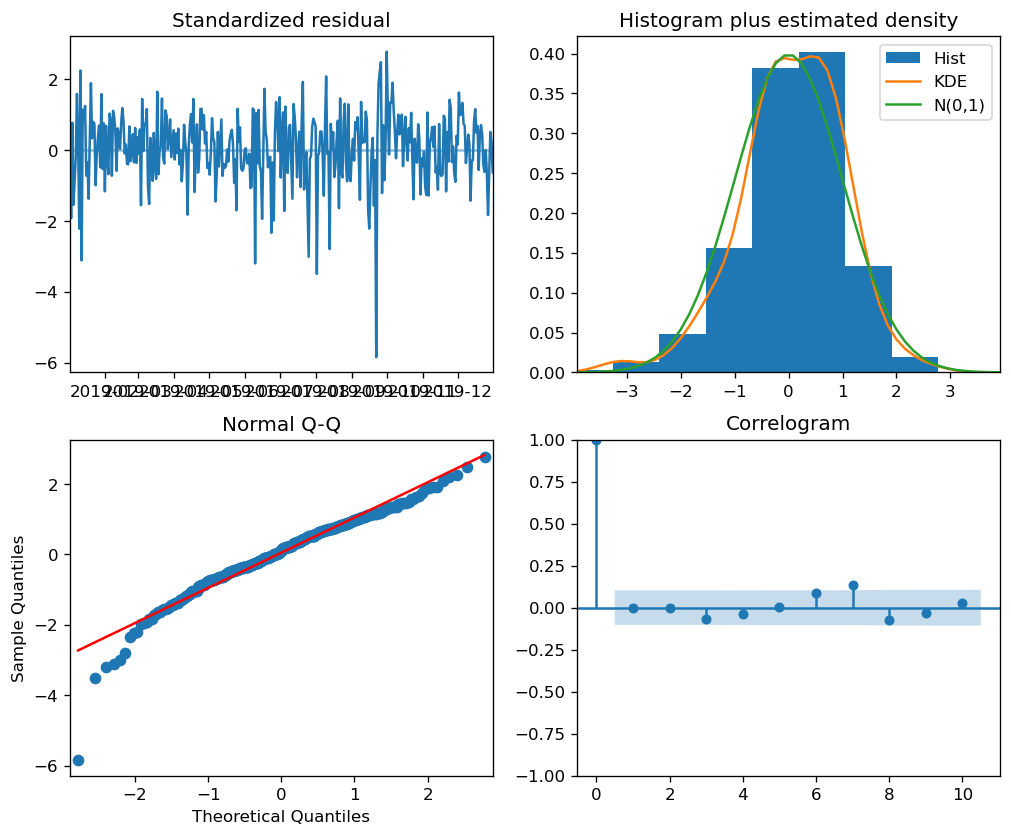

In [165]:
# Plot model diagnostics 
aamodel.plot_diagnostics(figsize=(10,8))
plt.show()

(Top left) Data is stationary. (Top right) Data has a fairly uniform distribution with a zero mean. (Bottom left) Data does not appear highly skewed. (Bottom right) residual errors are not autocorrelated. 
Based on these results, the model using auto arima's recommended orders appears fit to forecast. 

### Fit ARIMA model to very high margin dataset

In [166]:
# model very high margin items 
X = mcb
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

# calculate rmse
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE:', rmse)

Test RMSE: 0.3924200075701837


In [167]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -146.555
Date:                Wed, 15 Nov 2023   AIC                            299.111
Time:                        18:15:51   BIC                            310.794
Sample:                             0   HQIC                           303.755
                                - 364                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9802      0.051    -19.302      0.000      -1.080      -0.881
ma.L2          0.1170      0.046      2.536      0.011       0.027       0.207
sigma2         0.1307      0.006     21.227      0.000       0.119       0.143
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               245.91
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -0.97
Prob(H) (two-sided):                  0.06   Kurtosis:                         6.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

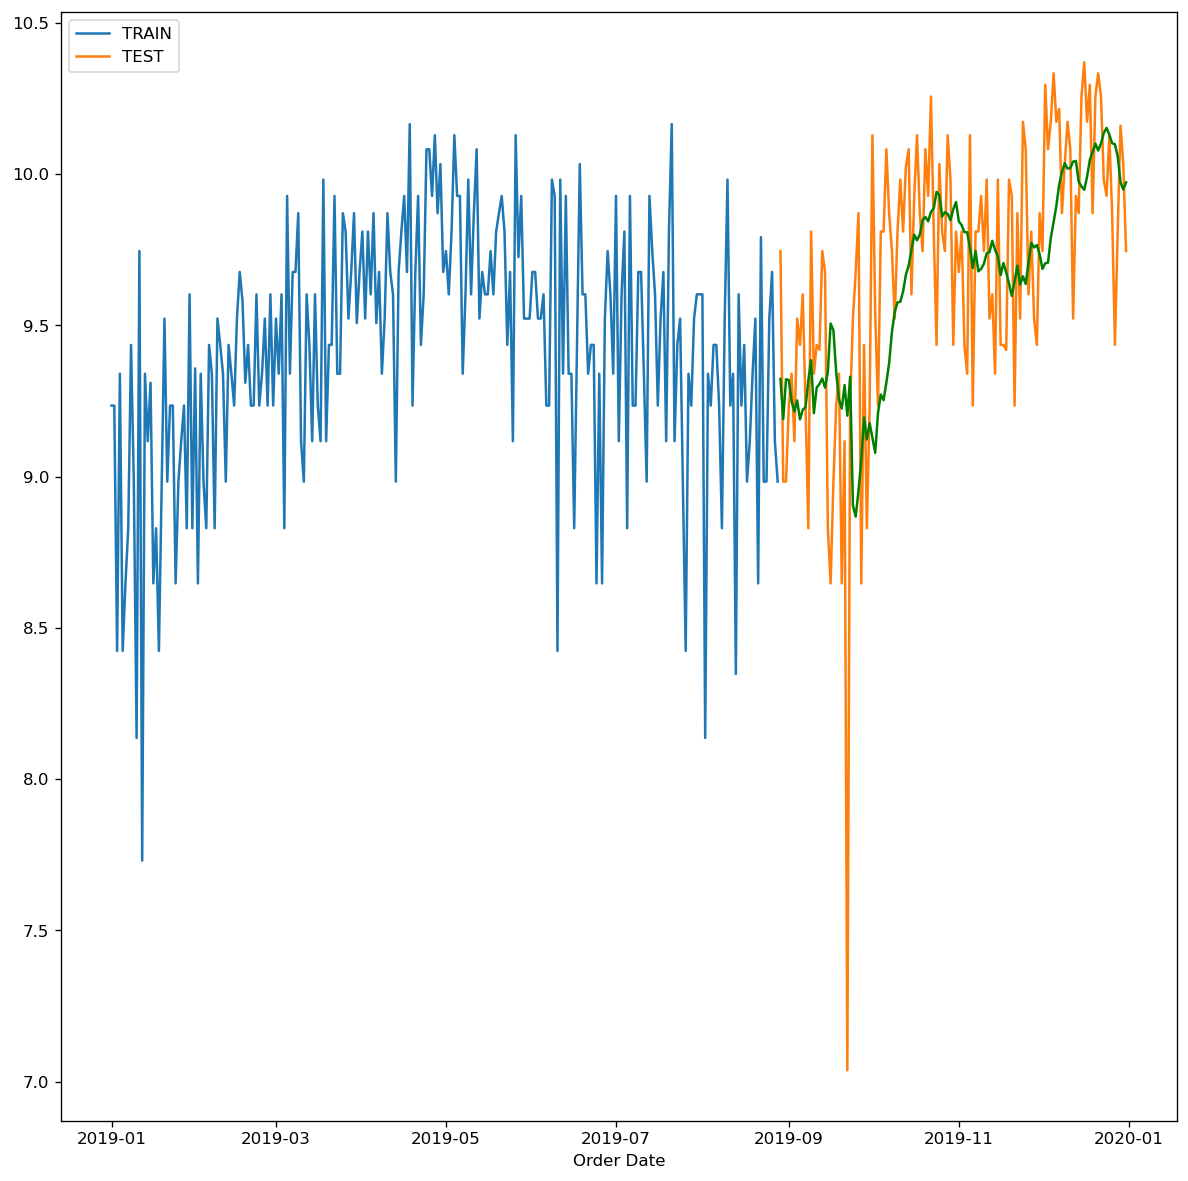

In [168]:
# plot predicted values against test values 
train.plot(legend=True, label='TRAIN')
test.plot(legend=True, label='TEST')
plt.plot(X[size:len(X)].index, predictions, color='green')

Predicted values do not reach the same extreme values as the measured values from the test set. The steep drop of sales in October is of particular concern becuase the prediction is much more mild than actual recorded sales. 

In [169]:
# generate a 30 day forcast from the model 

X = mcb
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in X]
predictions = list()

# walk-forward validation
for t in range(30):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)
    
#create an index for the predictions list 
dates2 = pd.date_range(start='1/1/2020', periods = 30)

In [170]:
#check predicted sales values for the next 10 days 
predictions[:10]

[9.963499235523276,
 9.96350139178531,
 9.963503330871845,
 9.96350496198486,
 9.963506418365345,
 9.963507670070129,
 9.963508766674087,
 9.963509705794307,
 9.963510547653243,
 9.963511260319999]

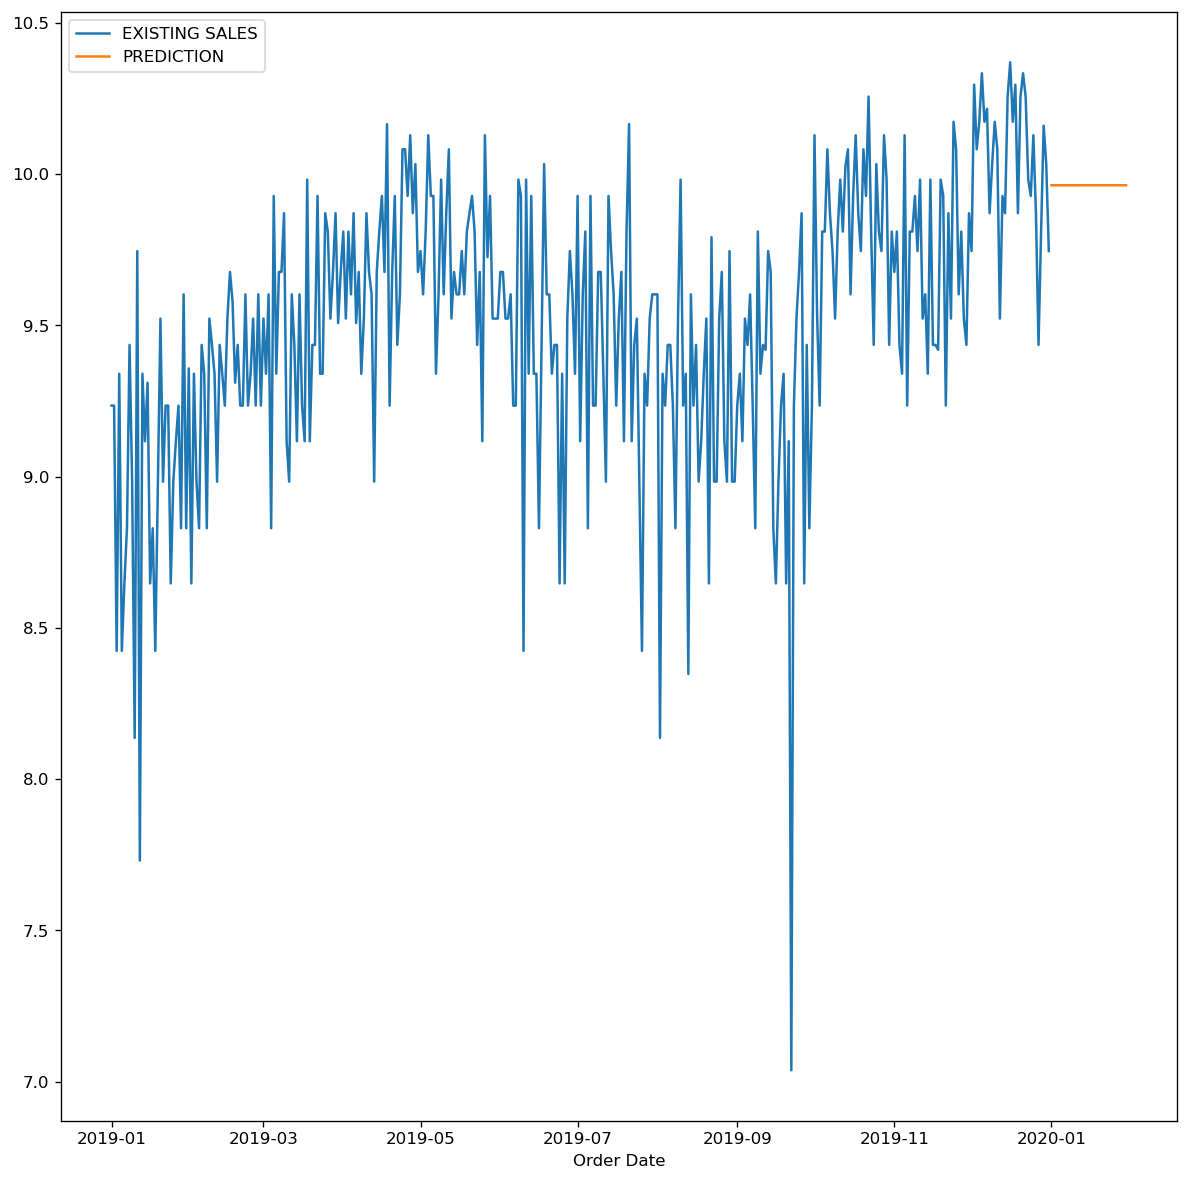

In [171]:
#plot the original sales numbers and the 30 day forecast 
mcb.plot(legend=True, label='EXISTING SALES')
plt.plot(dates2, predictions, label='PREDICTION')
plt.legend()

The model forcast shows a fairly linear sales pattern for the next 30 days. Sales numbers are near the peak of sales for the year, so the company should be optomistic about the sales of these items. 

## Build a model for the Low Margin data subset

### Prep the data 

In [172]:
# group the sales into daily sum 
lm = df2.groupby(df['Order Date'].dt.date)['margin'].sum()

# drop the last date because it appears to be only a half day of data 
lm = lm.drop(lm.index[365])

# log transform the series to adjust for positive skew 
lm = np.log(lm)

### Check for stationarity

In [173]:
# Utilize adf to test for stationarity 
result = adfuller(lm.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.952079
p-value: 0.307972


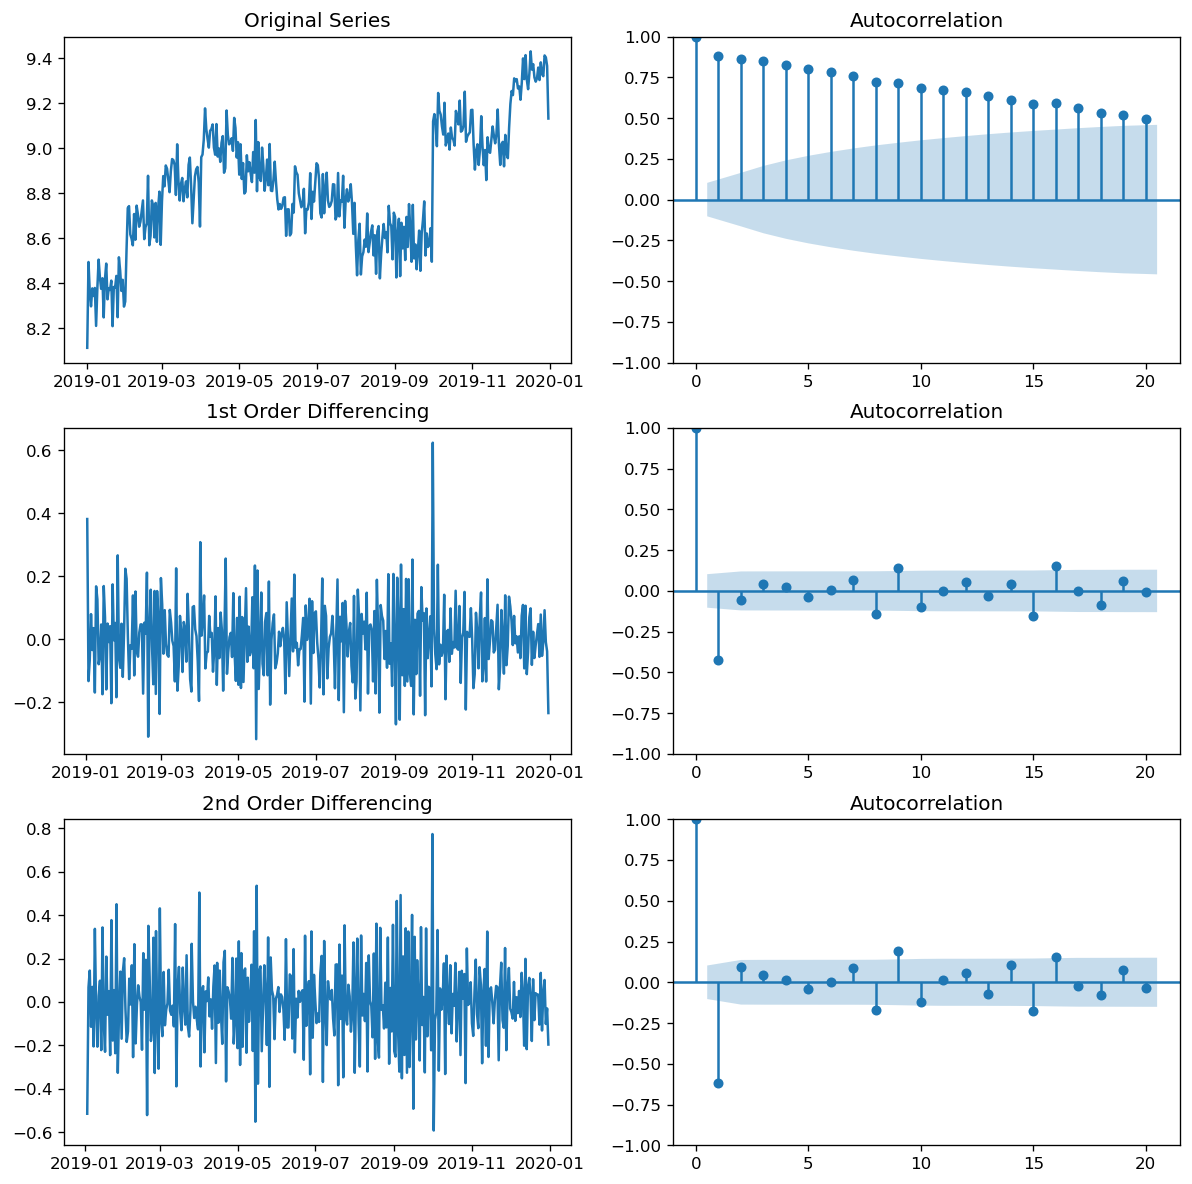

In [174]:
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(lm); axes[0, 0].set_title('Original Series')
plot_acf(lm, ax=axes[0, 1], lags=20)

# 1st Differencing
axes[1, 0].plot(lm.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(lm.diff().dropna(), ax=axes[1, 1], lags=20)

# 2nd Differencing
axes[2, 0].plot(lm.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(lm.diff().diff().dropna(), ax=axes[2, 1], lags=20)

plt.show()

### Determine optimal ARIMA orders for low margin dataset

In [175]:
# use autoarima to determine the optimal orders 
aamodel = pm.auto_arima(lm, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-612.620, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-499.557, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-571.639, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-614.608, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-501.362, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-612.622, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-613.424, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-614.847, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-612.884, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-612.893, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-573.189, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-610.949, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.585 seconds


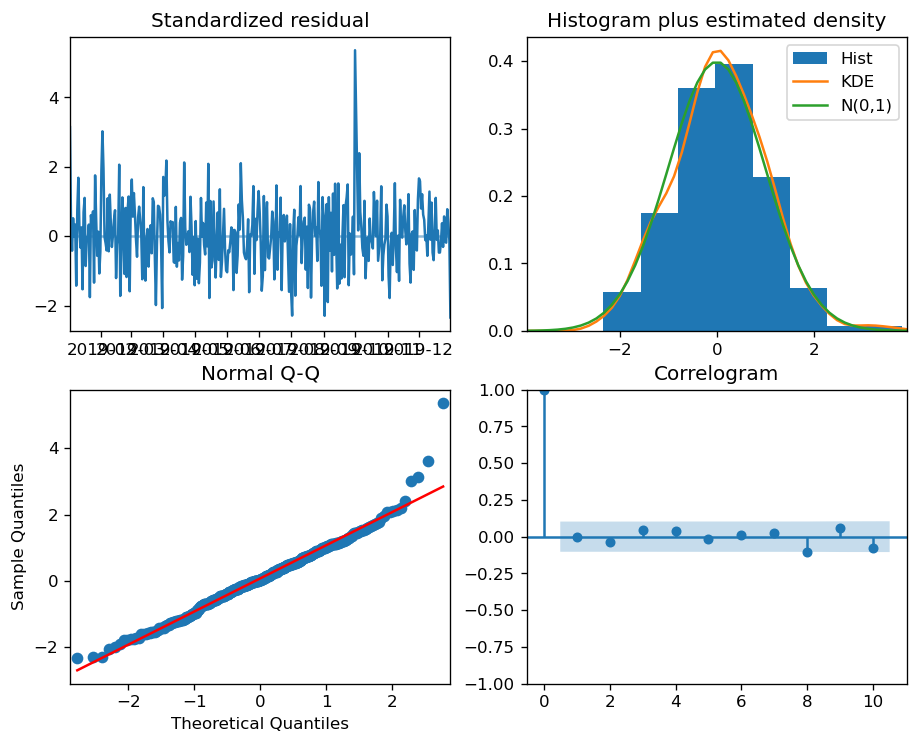

In [176]:
# plot the residual plots of the model
aamodel.plot_diagnostics(figsize=(9,7))
plt.show()

(Top left) Data is stationary. (Top right) Data has a fairly uniform distribution with a zero mean. (Bottom left) Data does not appear highly skewed. (Bottom right) residual errors are not autocorrelated. 
Based on these results, the model using auto arima's recommended orders appears fit to forecast. 

### Fit ARIMA model for low margin dataset

In [177]:
# model low margin items 
X = lm
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

# calculate rmse
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE:', rmse)

Test RMSE: 0.11186035495796498


In [178]:
#print model summary statistics 
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 310.823
Date:                Wed, 15 Nov 2023   AIC                           -617.646
Time:                        18:15:55   BIC                           -609.857
Sample:                             0   HQIC                          -614.550
                                - 364                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6143      0.033    -18.784      0.000      -0.678      -0.550
sigma2         0.0105      0.001     19.327      0.000       0.009       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                79.34
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.55
Prob(H) (two-sided):                  0.69   Kurtosis:                         5.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

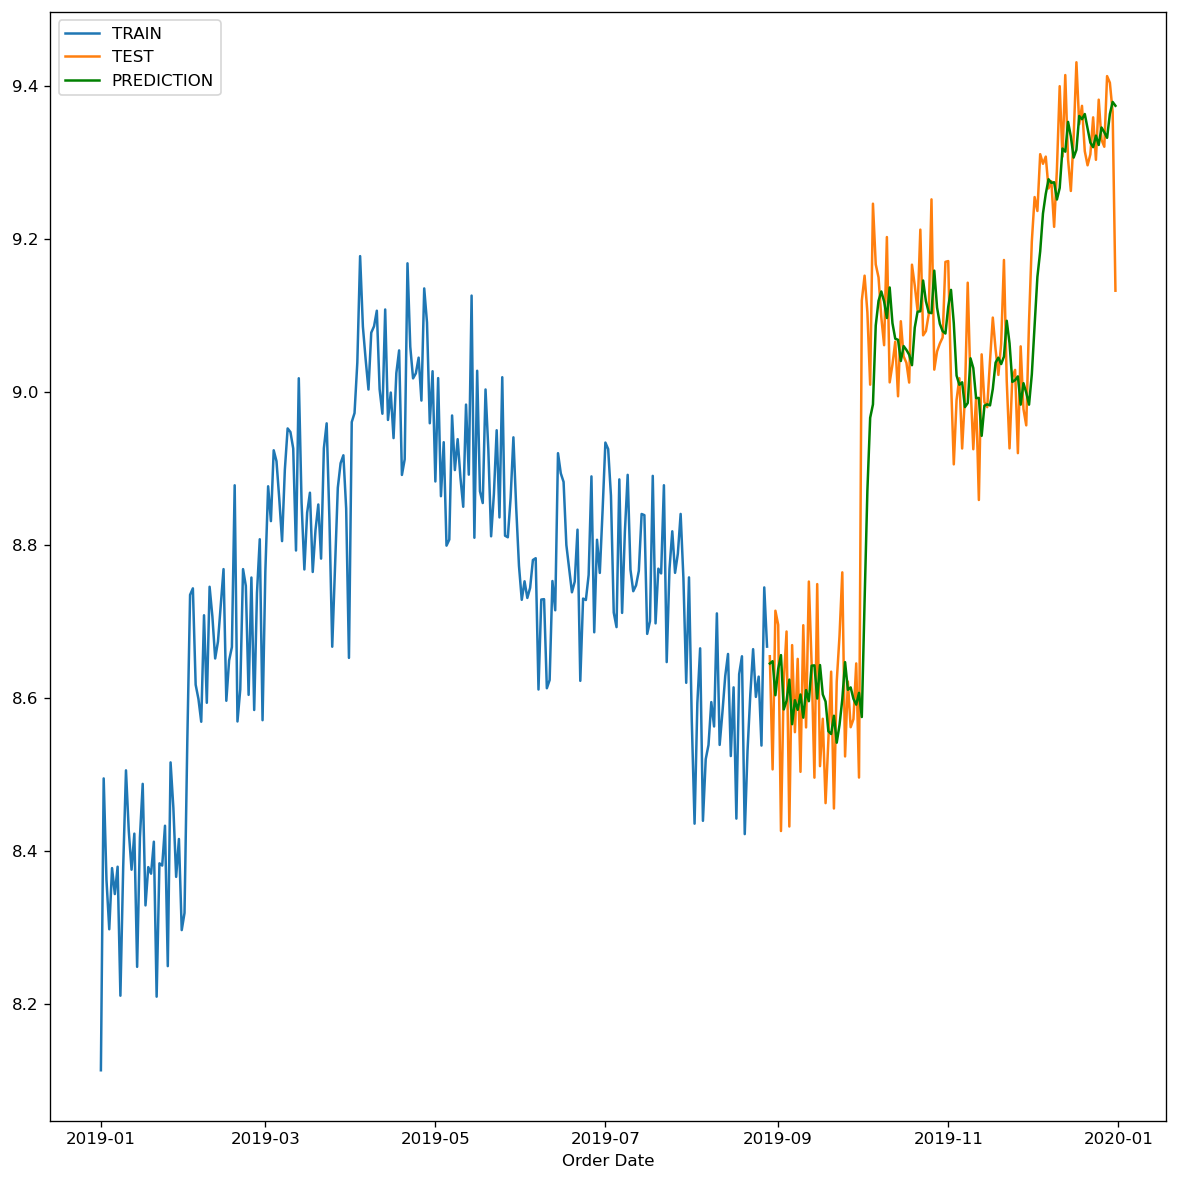

In [179]:
# plot predicted values against test values 
train.plot(legend=True, label='TRAIN')
test.plot(legend=True, label='TEST')
plt.plot(X[size:len(X)].index, predictions, color='green', label='PREDICTION')
plt.legend()

Predicted values do not reach the same extreme values as the measured values from the test set, but follow do follow the pattern of the revenue closely. Predicted values capture the steep climbs in revenue, but do not capture the drop towards the end of the time series. This drop might be predicted if there were more data available for training. 

In [180]:
# generate a 30 day forcast 
X = lm
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in X]
predictions = list()

# walk-forward validation
for t in range(30):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)

#create an index for the predictions list 
dates2 = pd.date_range(start='1/1/2020', periods = 30)

In [181]:
#check predicted sales values for the next 10 days 
predictions[:10]

[9.281137177491111,
 9.281135379734023,
 9.281136972662182,
 9.281137080778457,
 9.281137517926634,
 9.281137408864451,
 9.28113735053827,
 9.281137350925286,
 9.281137339187675,
 9.281137446228614]

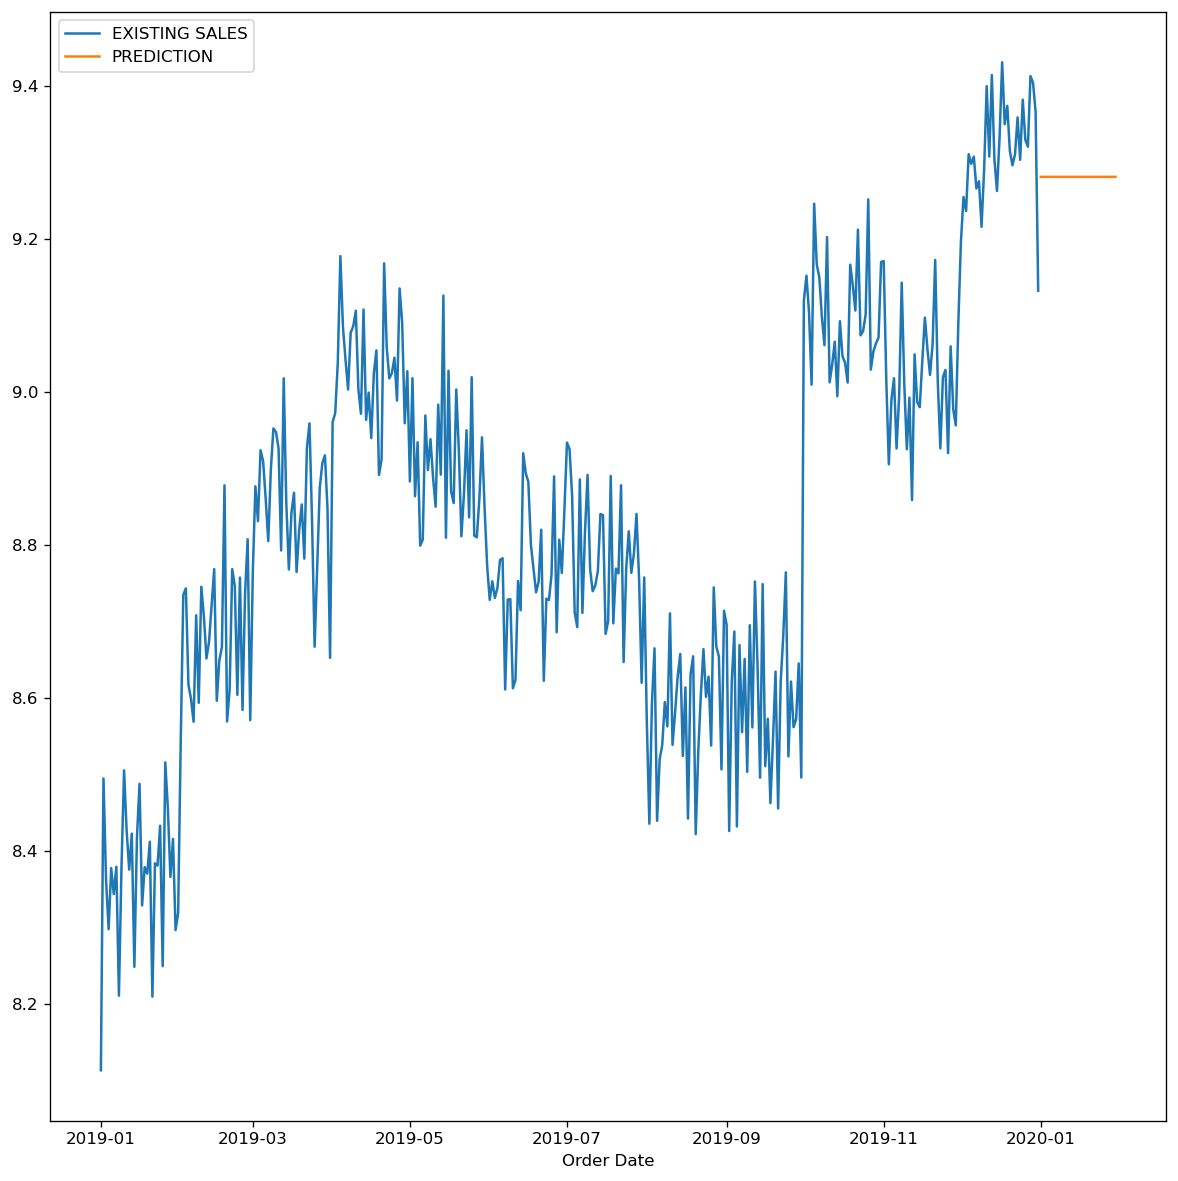

In [182]:
# plot predicted sales
lm.plot(legend=True, label='EXISTING SALES')
plt.plot(dates2, predictions, label='PREDICTION')
plt.legend()

The model forcast shows a fairly linear sales pattern for the next 30 days. Items in this subset appear to have a monthly sales pattern. The model predicts sales in the next month to be above average for this dataset, but below the peak sales for this year. 

## Build a model for the High Margin data subset

In [183]:
# group the sales into daily sum 
hm = outliers3.groupby(df['Order Date'].dt.date)['margin'].sum()

# drop the last row because it appears to be only a half day of data 
hm = hm.drop(hm.index[365])

# log transform the series to adjust for positive skew 
hm = np.log(hm)

In [184]:
# use adf to test for stationarity
result = adfuller(hm.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.876697
p-value: 0.343102


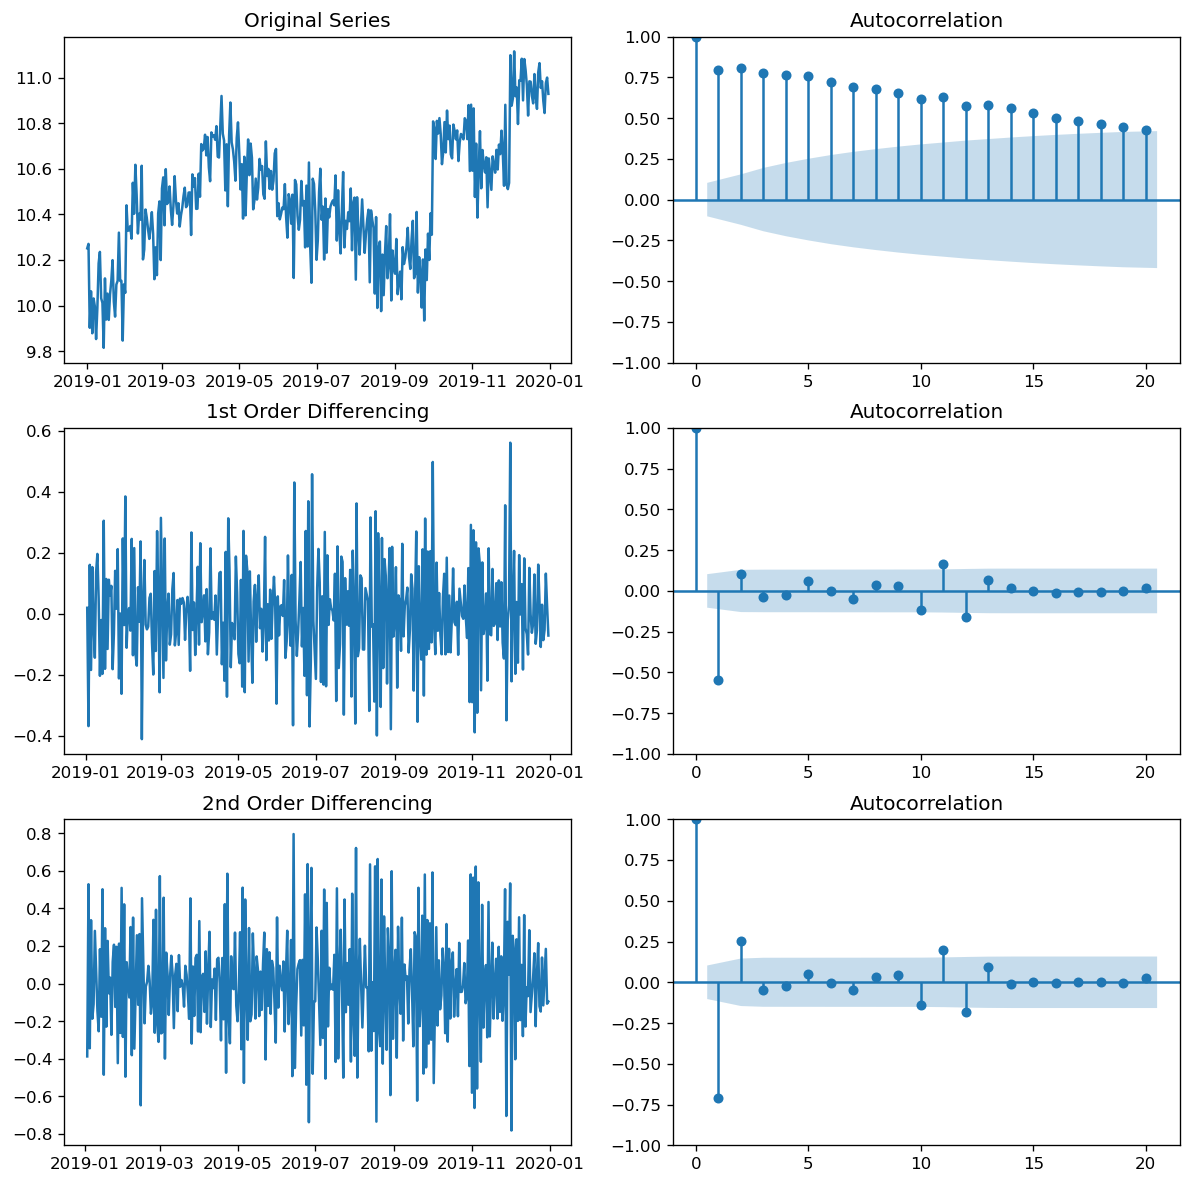

In [185]:
# use a plot and ACF to confirm stationarity results
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(hm); axes[0, 0].set_title('Original Series')
plot_acf(hm, ax=axes[0, 1], lags=20)

# 1st Differencing
axes[1, 0].plot(hm.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(hm.diff().dropna(), ax=axes[1, 1], lags=20)

# 2nd Differencing
axes[2, 0].plot(hm.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(hm.diff().diff().dropna(), ax=axes[2, 1], lags=20)

plt.show()

In [186]:
# use autoarima to determine the optimal orders 
aamodel = pm.auto_arima(hm, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-428.860, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-255.452, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-381.000, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-426.525, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-257.408, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-426.896, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-426.921, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-428.714, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-407.562, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-424.896, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-429.838, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-427.267, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-382.843, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-427.858, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]          

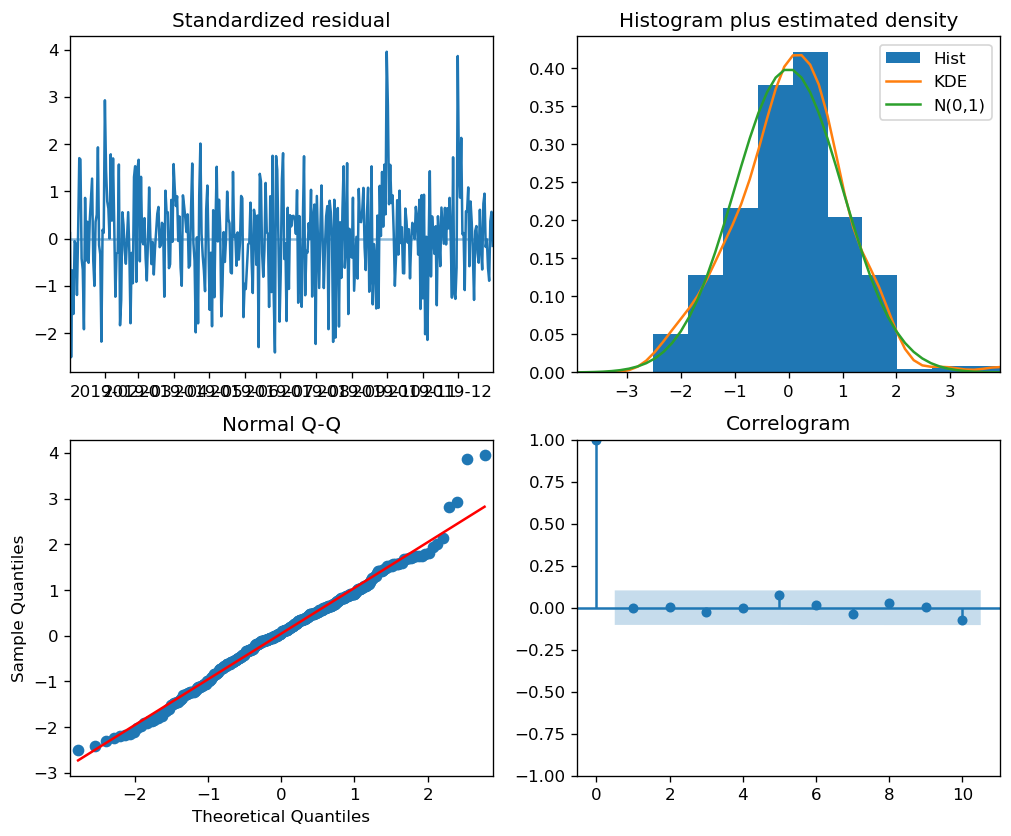

In [187]:
aamodel.plot_diagnostics(figsize=(10,8))
plt.show()

(Top left) Data is stationary. (Top right) Data has a fairly uniform distribution with a zero mean. (Bottom left) Data does not appear highly skewed. (Bottom right) residual errors are not autocorrelated. 
Based on these results, the model using auto arima's recommended orders appears fit to forecast.

### Fit an ARIMA model for High Margin dataset 

In [188]:
# model high margin items 
X = hm
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=10.949863, expected=10.929179
Test RMSE: 0.136


In [189]:
# print summary statistics for the model 
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 216.832
Date:                Wed, 15 Nov 2023   AIC                           -427.664
Time:                        18:16:01   BIC                           -415.981
Sample:                             0   HQIC                          -423.020
                                - 364                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1554      0.065     -2.394      0.017      -0.283      -0.028
ma.L1         -0.6262      0.050    -12.539      0.000      -0.724      -0.528
sigma2         0.0177      0.001     15.613      0.000       0.015       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.69
Prob(Q):                              0.99   Prob(JB):                         0.01
Heteroskedasticity (H):               1.04   Skew:                             0.11
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

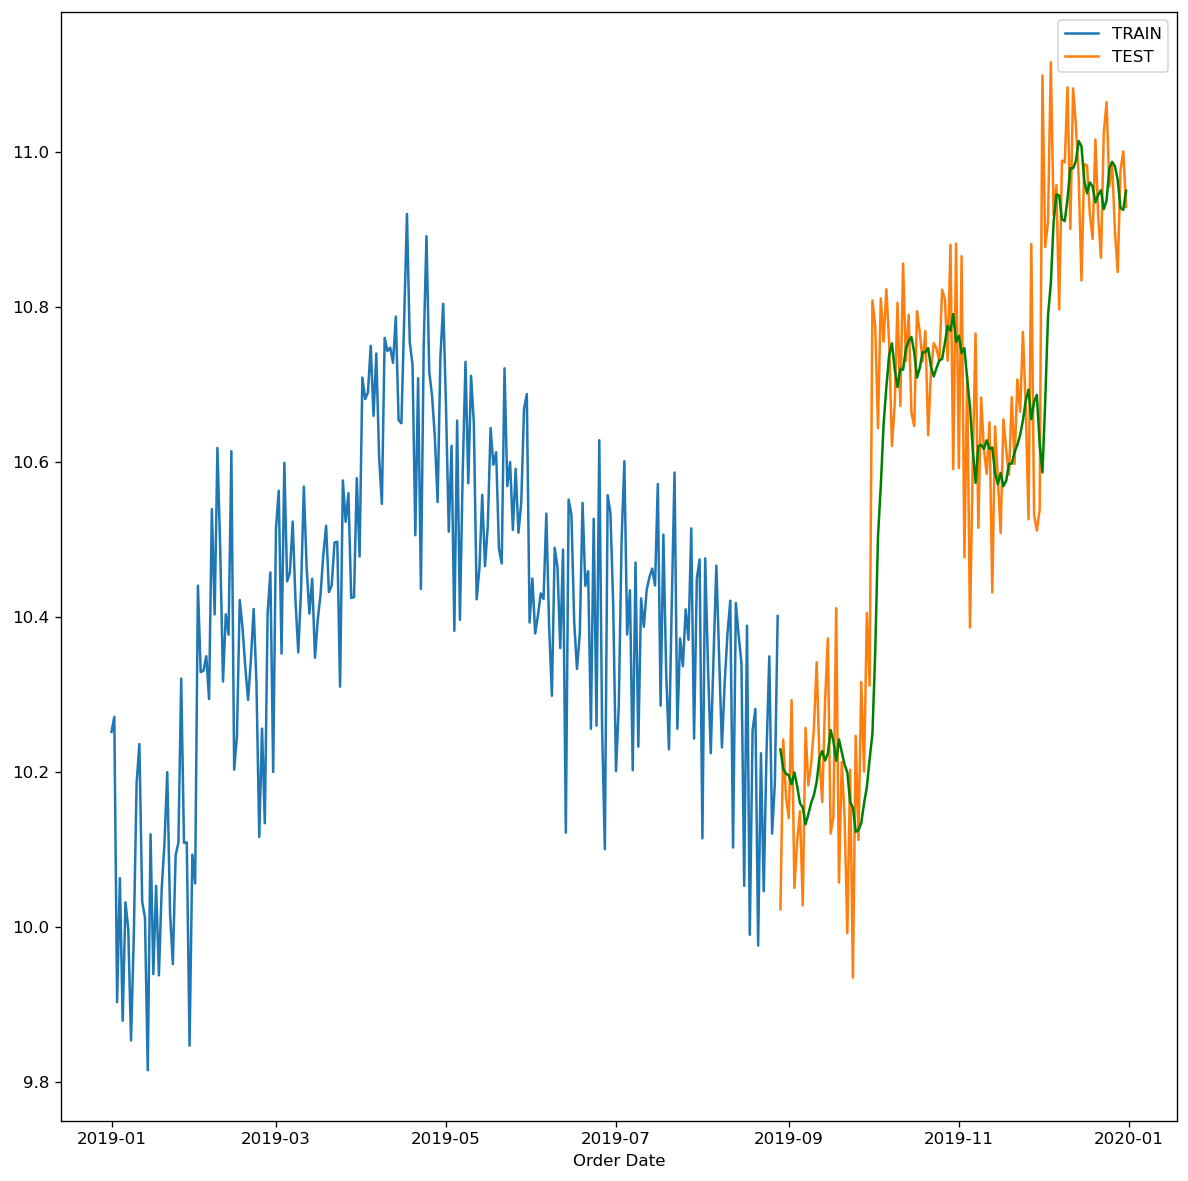

In [190]:
# plot predicted values against test set 
train.plot(legend=True, label='TRAIN')
test.plot(legend=True, label='TEST')
plt.plot(X[size:len(X)].index, predictions, color='green')

Predicted values do not reach the same extreme values as the measured values from the test set, but follow do follow the pattern of the revenue closely. 

In [191]:
# generate a 30 day forecast with the model 
X = hm
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in X]
predictions = list()

# walk-forward validation
for t in range(30):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)

#create an index for the predictions list 
dates2 = pd.date_range(start='1/1/2020', periods = 30)

In [192]:
#check predicted sales values for the next 10 days 
predictions[:10]

[10.953255159075395,
 10.949508635684774,
 10.950091607229503,
 10.950000891010498,
 10.950014983309863,
 10.950012790241706,
 10.950013127757698,
 10.950013074981388,
 10.950013083189914,
 10.950013081369175]

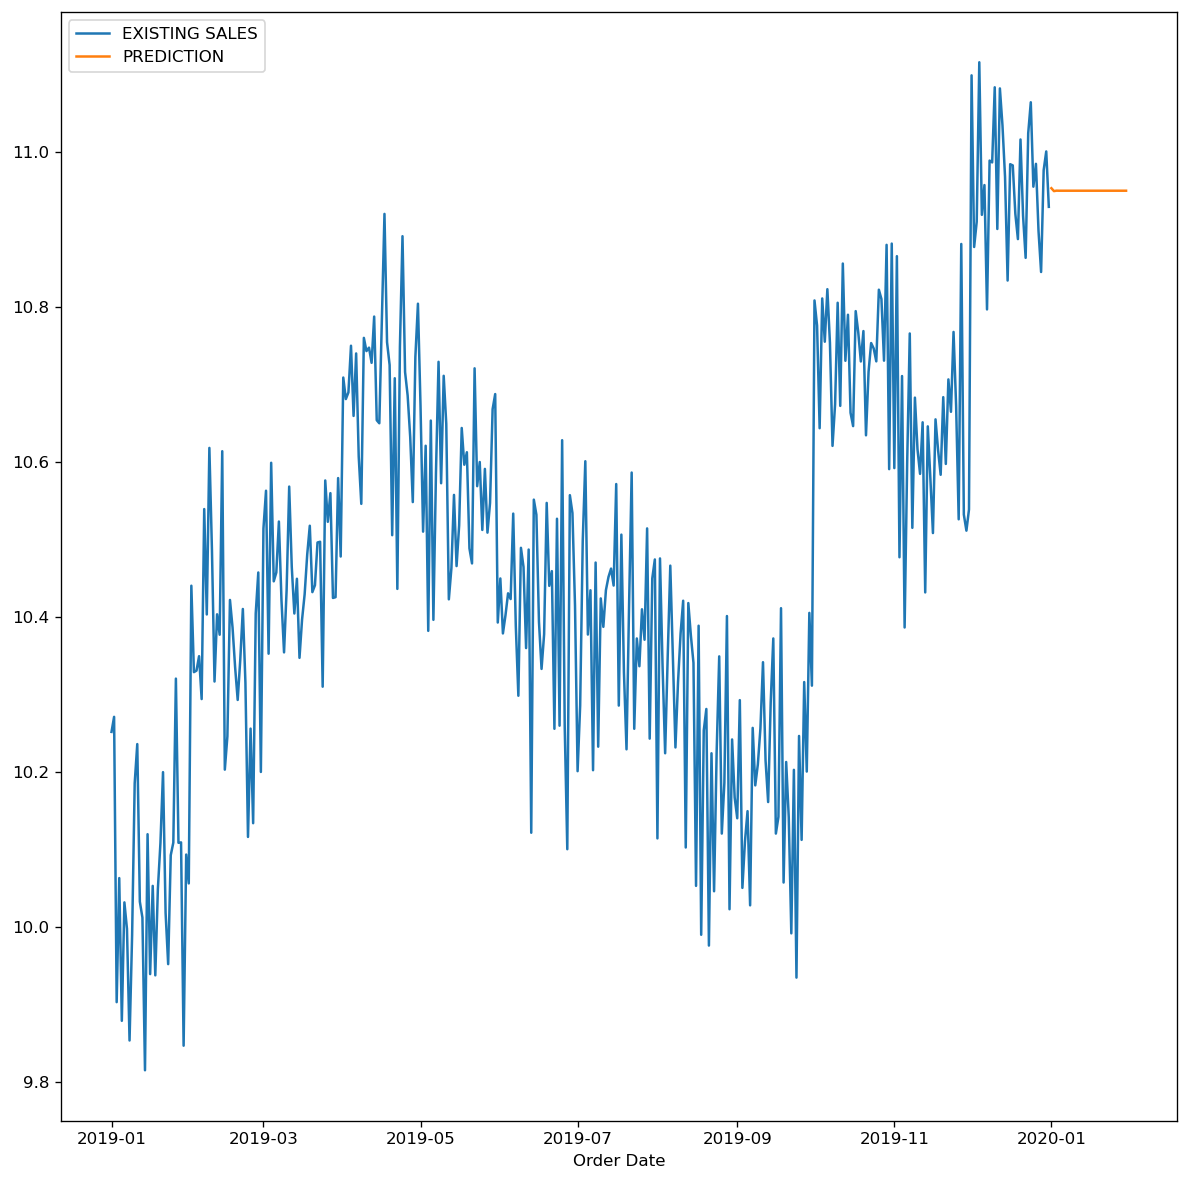

In [193]:
# plot forcasted values with historical sales numbers 
hm.plot(legend=True, label='EXISTING SALES')
plt.plot(dates2, predictions, label='PREDICTION')
plt.legend()

Predicted sales are fairly linear over the next 30 days. Our model suggests that sales in this category peaked last month and will experience a slight decline in next 30 days. 